In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/root/jupyter/SAs/batdongsan-datalake-v0-d1b3b2296e65.json'
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='batdongsan-datalake-v0')

In [184]:
from datetime import datetime

In [188]:
def printT( *arguments ):
    print(datetime.now().strftime( "%H:%M%S" ), *arguments)

In [191]:
printT(b)

NameError: name 'b' is not defined

In [183]:
def is_even_new( *arguments ):
    print("a", *arguments)
is_even_new("b")


a b


In [2]:
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
query="""
          select * from dwh.new_fact_product_tracking where date>='2021-10-01'
            """
job = bigquery_client.query(query)
CA_data=job.to_dataframe()

In [ ]:
query="""
        with 
ca as (
    select * from dwh.new_fact_product_tracking where date>='2021-10-01' and  date<'2021-12-01'
),
ga_pv as (
    SELECT ga_master_table.visit_date as date, 
    coalesce(ga_master_table_hits.hits_item_id,event_label_productid) as product_id,
    COUNT(CASE WHEN (ga_master_table_hits.hit_type = 'PAGE') THEN concat(ga_master_table.unique_intraaday_id, ga_master_table_hits.hit_time , ga_master_table_hits.hit_number  )  ELSE NULL END) AS ga_pageviews
FROM `batdongsan-datalake-v0.derived.ga_master_nested`
     AS ga_master_table
LEFT JOIN UNNEST(ga_master_table.hits) as ga_master_table_hits
WHERE  ga_master_table.visit_date  >='2021-10-01' and  ga_master_table.visit_date  <'2021-12-01' and content_group = 'Listing Details'
group by 1,2
),
ga_imp as (
     SELECT PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}')) date,
                REGEXP_REPLACE(product.productSKU, 'pr', '')                              product_id,
                COUNT(*)                                                                  ga_impression
         FROM `7384481.ga_sessions_*` ga_sessions
                  LEFT JOIN UNNEST(ga_sessions.hits) AS hits
                  LEFT JOIN UNNEST(hits.product) AS product
         WHERE PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}'))>='2021-10-01' and  PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}'))<'2021-12-01'
           AND product.isImpression IS TRUE
         GROUP BY date, product_id 
)
,
listing_des as (
         select distinct ProductID as product_id,   CreateByUser, CAST(BeginTime AS DATE) AS date_begin,
cast(EndTime as DATE)  as date_end
            from dwh.fact_listing_v2 f where PublishTime is not null 
            and cast(BeginTime AS DATE)>='2021-10-01' and cast(BeginTime AS DATE ) <'2021-12-01'
            ---group by 1,2
),
view_statistics as (
    SELECT
  REGEXP_REPLACE(ga_master_table_hits.event_label, 'prid=', '') as product_id,
    ga_master_table_hits.BDS_user_id  AS user_id,
    COUNT(CASE WHEN (ga_master_table_hits.hit_type = 'EVENT') THEN concat(ga_master_table.unique_intraaday_id, ga_master_table_hits.hit_time , ga_master_table_hits.hit_number  )  ELSE NULL END) AS ga_master_table_hits_total_event
FROM `batdongsan-datalake-v0.derived.ga_master_nested`
     AS ga_master_table
LEFT JOIN UNNEST(ga_master_table.hits) as ga_master_table_hits
WHERE  ga_master_table.visit_date  >= '2021-10-01' and (ga_master_table_hits.event_action ) = 'Click-View Statistics'
GROUP BY
    1,2
), 
combine as (
    select date, product_id from ca union distinct
    select date, cast(product_id as int) from ga_pv union distinct 
    select date, cast(product_id as int) from ga_imp where product_id not like '%a%'
)


select c.*, ca.total_impression, ca.total_pageview,  a.ga_pageviews , b.ga_impression,
  CreateByUser, date_begin, date_end,
   s.user_id 
 from combine c
left join ca as ca on ca.date=c.date and ca.product_id=c.product_id
left join ga_pv a on
cast(c.product_id as string) = cast(a.product_id as string) and a.date=c.date
full outer join  ga_imp b on 
cast(c.product_id as string) = cast(b.product_id as string) and b.date=c.date
 join  listing_des  as l on c.product_id=l.product_id and c.date>= date_begin and c.date<= date_end
left join view_statistics s on l.CreateByUser=CAST(s.user_id AS INT)

            """
job = bigquery_client.query(query)
combine_data=job.to_dataframe()

In [3]:
query="""
      ---   create or replace table chambt_temp.t10_compare_pv_imp as
 with 
ca as (
    select date, product_id, case when total_impression>0 then total_impression else null end as total_impression,
    case when total_pageview>0 then total_pageview else null end as total_pageview
      from dwh.new_fact_product_tracking where date>='2021-10-01' and  date<'2021-12-01'
),
ga_pv as (
    SELECT ga_master_table.visit_date as date, 
    coalesce(ga_master_table_hits.hits_item_id,event_label_productid) as product_id,
    COUNT(CASE WHEN (ga_master_table_hits.hit_type = 'PAGE') THEN concat(ga_master_table.unique_intraaday_id, ga_master_table_hits.hit_time , ga_master_table_hits.hit_number  )  ELSE NULL END) AS ga_pageviews
FROM `batdongsan-datalake-v0.derived.ga_master_nested`
     AS ga_master_table
LEFT JOIN UNNEST(ga_master_table.hits) as ga_master_table_hits
WHERE  ga_master_table.visit_date  >='2021-10-01' and  ga_master_table.visit_date<'2021-12-01' and content_group = 'Listing Details'
group by 1,2
),
ga_imp as (
     SELECT PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}')) date,
                REGEXP_REPLACE(product.productSKU, 'pr', '')                              product_id,
                COUNT(*)                                                                  ga_impression
         FROM `7384481.ga_sessions_*` ga_sessions
                  LEFT JOIN UNNEST(ga_sessions.hits) AS hits
                  LEFT JOIN UNNEST(hits.product) AS product
         WHERE PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}'))>='2021-10-01' and PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}'))<'2021-12-01'
           AND product.isImpression IS TRUE
         GROUP BY date, product_id 
)
,
listing_des as (
         select distinct ProductID as product_id,   CreateByUser, VipType ---, CAST(BeginTime AS DATE) AS date_begin,
---cast(EndTime as DATE)  as date_end
            from dwh.fact_listing_v2 f where PublishTime is not null 
            and CAST(EndTime AS DATE)<'2021-12-01' and  CAST(BeginTime AS DATE)>='2021-10-01'
),
view_statistics as (
    SELECT
  REGEXP_REPLACE(ga_master_table_hits.event_label, 'prid=', '') as product_id,
    ga_master_table_hits.BDS_user_id  AS user_id,
    COUNT(CASE WHEN (ga_master_table_hits.hit_type = 'EVENT') THEN concat(ga_master_table.unique_intraaday_id, ga_master_table_hits.hit_time , ga_master_table_hits.hit_number  )  ELSE NULL END) AS ga_master_table_hits_total_event
FROM `batdongsan-datalake-v0.derived.ga_master_nested`
     AS ga_master_table
LEFT JOIN UNNEST(ga_master_table.hits) as ga_master_table_hits
WHERE  ga_master_table.visit_date  >= '2021-10-01' and (ga_master_table_hits.event_action ) = 'Click-View Statistics'
GROUP BY
    1,2
), 
combine as (
    select date, product_id from ca union distinct
    select date, cast(product_id as int) from ga_pv union distinct 
    select date, cast(product_id as int) from ga_imp where product_id not like '%a%'
),
m as (

select c.*, ca.total_impression, ca.total_pageview,  a.ga_pageviews , b.ga_impression,
  CreateByUser,VipType, --date_begin, date_end,
   s.user_id , u.usage_type


 from combine c
left join ca as ca on ca.date=c.date and ca.product_id=c.product_id
left join ga_pv a on
cast(c.product_id as string) = cast(a.product_id as string) and a.date=c.date
full outer join  ga_imp b on 
cast(c.product_id as string) = cast(b.product_id as string) and b.date=c.date
join  listing_des  as l on c.product_id=l.product_id ---and c.date>=date_begin and c.date<=date_end
left join view_statistics s on l.CreateByUser=CAST(s.user_id AS INT)
--from chambt_temp.t10_compare_ca_ga as a
 left join chambt_temp.user_cohort as u on l.CreateByUser=u.user_id
where c.product_id is not null)
select m.*, 
 CASE  WHEN  ga_impression is null and total_impression>0 then -1
       when  ( ga_impression is null or  ga_impression=0)  and (total_impression=0 or total_impression is null) then 0
       when  ga_impression > 0 and  total_impression is null then 1

           WHEN ROUND((NULLIF( ga_impression, 0) - NULLIF(total_impression, 0)) * 100 /
                      NULLIF(total_impression, 0)) =
                0 THEN 0
           WHEN ROUND((NULLIF(ga_impression, 0) - NULLIF(total_impression, 0)) * 100 /
                      NULLIF(total_impression, 0)) != 0 AND
                NULLIF(total_impression , 0) > NULLIF( ga_impression ,0) THEN -1
           ELSE 1 END                                                                   AS higher_ga_imp,
       (NULLIF(total_impression,0) -  NULLIF(ga_impression,0))                       diff_imp,
       ROUND((NULLIF(total_impression, 0) - NULLIF(ga_impression, 0)) * 100 /
             NULLIF(total_impression, 0))                                  diff_rate_imp,

       CASE WHEN ga_pageviews is null and total_pageview>0 then -1
       when  (ga_pageviews is null or ga_pageviews=0)  and (total_pageview=0 or total_pageview is null) then 0
       when ga_pageviews > 0 and  total_pageview is null then 1
           WHEN ROUND((NULLIF( ga_pageviews, 0) - NULLIF(total_pageview, 0)) * 100 /
                      NULLIF(total_pageview, 0)) =
                0 THEN 0
           WHEN ROUND((NULLIF(ga_pageviews, 0) - NULLIF(total_pageview, 0)) * 100 /
                      NULLIF(total_pageview, 0)) != 0 AND
               NULLIF( total_pageview ,0) >  NULLIF(ga_pageviews,0) THEN -1
           ELSE 1 END                                                                   AS higher_ga_pv,
       (NULLIF(total_pageview,0) -  NULLIF(ga_pageviews,0))                       diff_pv,
       ROUND((NULLIF(total_pageview, 0) - NULLIF(ga_pageviews, 0)) * 100 /
             NULLIF(total_pageview, 0))                                  diff_rate_pv
 from m

            """
job = bigquery_client.query(query)
combine_data=job.to_dataframe()

In [4]:
query="""
      ---   create or replace table chambt_temp.t10_compare_pv_imp as
 with 
ca as (
    select date, product_id, case when total_impression>0 then total_impression else null end as total_impression,
    case when total_pageview>0 then total_pageview else null end as total_pageview
      from dwh.new_fact_product_tracking where date>='2021-10-01' and  date<'2021-12-01'
),
ga_pv as (
    SELECT ga_master_table.visit_date as date, 
    coalesce(ga_master_table_hits.hits_item_id,event_label_productid) as product_id,
    COUNT(CASE WHEN (ga_master_table_hits.hit_type = 'PAGE') THEN concat(ga_master_table.unique_intraaday_id, ga_master_table_hits.hit_time , ga_master_table_hits.hit_number  )  ELSE NULL END) AS ga_pageviews
FROM `batdongsan-datalake-v0.derived.ga_master_nested`
     AS ga_master_table
LEFT JOIN UNNEST(ga_master_table.hits) as ga_master_table_hits
WHERE  ga_master_table.visit_date  >='2021-10-01' and  ga_master_table.visit_date<'2021-12-01' and content_group = 'Listing Details'
group by 1,2
),
ga_imp as (
     SELECT PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}')) date,
                REGEXP_REPLACE(product.productSKU, 'pr', '')                              product_id,
                COUNT(*)                                                                  ga_impression
         FROM `7384481.ga_sessions_*` ga_sessions
                  LEFT JOIN UNNEST(ga_sessions.hits) AS hits
                  LEFT JOIN UNNEST(hits.product) AS product
         WHERE PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}'))>='2021-10-01' and PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}'))<'2021-12-01'
           AND product.isImpression IS TRUE
         GROUP BY date, product_id 
)
,
listing_des as (
         select distinct ProductID as product_id,   CreateByUser, VipType , CAST(BeginTime AS DATE) AS date_begin,
cast(EndTime as DATE)  as date_end
            from dwh.fact_listing_v2 f where PublishTime is not null 
            and CAST(BeginTime AS DATE)<'2021-12-01' and  CAST(BeginTime AS DATE)>='2021-10-01'
),
view_statistics as (
    SELECT
  REGEXP_REPLACE(ga_master_table_hits.event_label, 'prid=', '') as product_id,
    ga_master_table_hits.BDS_user_id  AS user_id,
    COUNT(CASE WHEN (ga_master_table_hits.hit_type = 'EVENT') THEN concat(ga_master_table.unique_intraaday_id, ga_master_table_hits.hit_time , ga_master_table_hits.hit_number  )  ELSE NULL END) AS ga_master_table_hits_total_event
FROM `batdongsan-datalake-v0.derived.ga_master_nested`
     AS ga_master_table
LEFT JOIN UNNEST(ga_master_table.hits) as ga_master_table_hits
WHERE  ga_master_table.visit_date  >= '2021-10-01' and (ga_master_table_hits.event_action ) = 'Click-View Statistics'
GROUP BY
    1,2
), 
combine as (
    select date, product_id from ca union distinct
    select date, cast(product_id as int) from ga_pv union distinct 
    select date, cast(product_id as int) from ga_imp where product_id not like '%a%'
),
m as (

select c.*, ca.total_impression, ca.total_pageview,  a.ga_pageviews , b.ga_impression,
  CreateByUser,VipType, --date_begin, date_end,
   s.user_id , u.usage_type


 from combine c
left join ca as ca on ca.date=c.date and ca.product_id=c.product_id
left join ga_pv a on
cast(c.product_id as string) = cast(a.product_id as string) and a.date=c.date
full outer join  ga_imp b on 
cast(c.product_id as string) = cast(b.product_id as string) and b.date=c.date
join  listing_des  as l on c.product_id=l.product_id and c.date>=date_begin and c.date<=date_end
left join view_statistics s on l.CreateByUser=CAST(s.user_id AS INT)
--from chambt_temp.t10_compare_ca_ga as a
 left join chambt_temp.user_cohort as u on l.CreateByUser=u.user_id
where c.product_id is not null)
select m.*, 
 CASE  WHEN  ga_impression is null and total_impression>0 then -1
       when  ( ga_impression is null or  ga_impression=0)  and (total_impression=0 or total_impression is null) then 0
       when  ga_impression > 0 and  total_impression is null then 1

           WHEN ROUND((NULLIF( ga_impression, 0) - NULLIF(total_impression, 0)) * 100 /
                      NULLIF(total_impression, 0)) =
                0 THEN 0
           WHEN ROUND((NULLIF(ga_impression, 0) - NULLIF(total_impression, 0)) * 100 /
                      NULLIF(total_impression, 0)) != 0 AND
                NULLIF(total_impression , 0) > NULLIF( ga_impression ,0) THEN -1
           ELSE 1 END                                                                   AS higher_ga_imp,
       (NULLIF(total_impression,0) -  NULLIF(ga_impression,0))                       diff_imp,
       ROUND((NULLIF(total_impression, 0) - NULLIF(ga_impression, 0)) * 100 /
             NULLIF(total_impression, 0))                                  diff_rate_imp,

       CASE WHEN ga_pageviews is null and total_pageview>0 then -1
       when  (ga_pageviews is null or ga_pageviews=0)  and (total_pageview=0 or total_pageview is null) then 0
       when ga_pageviews > 0 and  total_pageview is null then 1
           WHEN ROUND((NULLIF( ga_pageviews, 0) - NULLIF(total_pageview, 0)) * 100 /
                      NULLIF(total_pageview, 0)) =
                0 THEN 0
           WHEN ROUND((NULLIF(ga_pageviews, 0) - NULLIF(total_pageview, 0)) * 100 /
                      NULLIF(total_pageview, 0)) != 0 AND
               NULLIF( total_pageview ,0) >  NULLIF(ga_pageviews,0) THEN -1
           ELSE 1 END                                                                   AS higher_ga_pv,
       (NULLIF(total_pageview,0) -  NULLIF(ga_pageviews,0))                       diff_pv,
       ROUND((NULLIF(total_pageview, 0) - NULLIF(ga_pageviews, 0)) * 100 /
             NULLIF(total_pageview, 0))                                  diff_rate_pv
 from m

            """
job = bigquery_client.query(query)
combine_data_2=job.to_dataframe()

In [5]:
combine_data['date']=pd.to_datetime(combine_data['date'])
combine_data_2['date']=pd.to_datetime(combine_data_2['date'])

In [6]:
combine_data_3 = (combine_data
                  .merge(combine_data_2[['product_id','date']].assign(duration=1), on=['product_id','date'], how='left')
                  .query('duration.isnull()')
                 )

In [2]:
# query="""
#         select * from  chambt_temp.t10_compare_pv_imp

#             """
# job = bigquery_client.query(query)
# combine_data=job.to_dataframe()

In [7]:
combine_data['diff_pv']=np.where(combine_data['diff_pv'].notnull(),combine_data['diff_pv'],combine_data['total_pageview'])
combine_data['diff_pv']=np.where(combine_data['total_pageview'].isnull(),-1*combine_data['ga_pageviews'],combine_data['diff_pv'])

In [8]:
combine_data_2['diff_pv']=np.where(combine_data_2['diff_pv'].notnull(),combine_data_2['diff_pv'],combine_data_2['total_pageview'])
combine_data_2['diff_pv']=np.where(combine_data_2['total_pageview'].isnull(),-1*combine_data_2['ga_pageviews'],combine_data_2['diff_pv'])
combine_data_3['diff_pv']=np.where(combine_data_3['diff_pv'].notnull(),combine_data_3['diff_pv'],combine_data_3['total_pageview'])
combine_data_3['diff_pv']=np.where(combine_data_3['total_pageview'].isnull(),-1*combine_data_3['ga_pageviews'],combine_data_3['diff_pv'])

In [9]:
combine_data['diff_imp']=np.where(combine_data['diff_imp'].notnull(),combine_data['diff_imp'],combine_data['total_impression'])
combine_data['diff_imp']=np.where(combine_data['total_impression'].isnull(),-1*combine_data['ga_impression'],combine_data['diff_imp'])

In [10]:
combine_data['diff_rate_pv']=np.where((combine_data['diff_rate_pv'].isnull())&(combine_data['total_pageview'].isnull())
                                      &(combine_data['diff_pv'].notnull()),-999, combine_data['diff_rate_pv'])
combine_data['diff_rate_pv']=np.where((combine_data['diff_rate_pv'].isnull())&(combine_data['ga_pageviews'].isnull())
                                      &(combine_data['diff_pv'].notnull()),999, combine_data['diff_rate_pv'])

combine_data['diff_rate_imp']=np.where((combine_data['diff_rate_imp'].isnull())&(combine_data['total_impression'].isnull())
                                      &(combine_data['diff_imp'].notnull()),-999, combine_data['diff_rate_imp'])
combine_data['diff_rate_imp']=np.where((combine_data['diff_rate_imp'].isnull())&(combine_data['ga_impression'].isnull())
                                      &(combine_data['diff_imp'].notnull()),999, combine_data['diff_rate_imp'])

In [11]:
combine_data_2['diff_rate_pv']=np.where((combine_data_2['diff_rate_pv'].isnull())&(combine_data_2['total_pageview'].isnull())
                                      &(combine_data_2['diff_pv'].notnull()),-999, combine_data_2['diff_rate_pv'])
combine_data_2['diff_rate_pv']=np.where((combine_data_2['diff_rate_pv'].isnull())&(combine_data_2['ga_pageviews'].isnull())
                                      &(combine_data_2['diff_pv'].notnull()),999, combine_data_2['diff_rate_pv'])

combine_data_3['diff_rate_pv']=np.where((combine_data_3['diff_rate_pv'].isnull())&(combine_data_3['total_pageview'].isnull())
                                      &(combine_data_3['diff_pv'].notnull()),-999, combine_data_3['diff_rate_pv'])
combine_data_3['diff_rate_pv']=np.where((combine_data_3['diff_rate_pv'].isnull())&(combine_data_3['ga_pageviews'].isnull())
                                      &(combine_data_3['diff_pv'].notnull()),999, combine_data_3['diff_rate_pv'])



In [12]:
combine_data_3['ga_pageviews']=np.where((combine_data_3['ga_pageviews'].isnull())&(combine_data_3['total_pageview'].notnull()),
                                        0,combine_data_3['ga_pageviews'])
combine_data_3['total_pageview']=np.where((combine_data_3['ga_pageviews'].notnull())&(combine_data_3['total_pageview'].isnull()),
                                        0,combine_data_3['total_pageview'])

combine_data_2['ga_pageviews']=np.where((combine_data_2['ga_pageviews'].isnull())&(combine_data_2['total_pageview'].notnull()),
                                        0,combine_data_2['ga_pageviews'])
combine_data_2['total_pageview']=np.where((combine_data_2['ga_pageviews'].notnull())&(combine_data_2['total_pageview'].isnull()),
                                        0,combine_data_2['total_pageview'])

combine_data['ga_pageviews']=np.where((combine_data['ga_pageviews'].isnull())&(combine_data['total_pageview'].notnull()),
                                        0,combine_data['ga_pageviews'])
combine_data['total_pageview']=np.where((combine_data['ga_pageviews'].notnull())&(combine_data['total_pageview'].isnull()),
                                        0,combine_data['total_pageview'])

In [13]:
combine_data['diff_pv']=np.where((combine_data['total_pageview']==0)&(combine_data['ga_pageviews']==0), np.NaN, combine_data['diff_pv'])
combine_data_2['diff_pv']=np.where((combine_data_2['total_pageview']==0)&(combine_data_2['ga_pageviews']==0), np.NaN, combine_data_2['diff_pv'])
combine_data_3['diff_pv']=np.where((combine_data_3['total_pageview']==0)&(combine_data_3['ga_pageviews']==0), np.NaN, combine_data_3['diff_pv'])

In [14]:
combine_data['higher_ga_pv']=np.where(combine_data['diff_pv'].isnull(), np.NaN, combine_data['higher_ga_pv'])
combine_data['higher_ga_pv']=np.where(combine_data['total_pageview']>combine_data['ga_pageviews'], -1, combine_data['higher_ga_pv'])

combine_data_2['higher_ga_pv']=np.where(combine_data_2['diff_pv'].isnull(), np.NaN, combine_data_2['higher_ga_pv'])
combine_data_2['higher_ga_pv']=np.where(combine_data_2['total_pageview']>combine_data_2['ga_pageviews'], -1, combine_data_2['higher_ga_pv'])

combine_data_3['higher_ga_pv']=np.where(combine_data_3['diff_pv'].isnull(), np.NaN, combine_data_3['higher_ga_pv'])
combine_data_3['higher_ga_pv']=np.where(combine_data_3['total_pageview']>combine_data_3['ga_pageviews'], -1, combine_data_3['higher_ga_pv'])

In [15]:
combine_data["order_date"] = combine_data.groupby("product_id")["date"].rank("dense", ascending=True)
# combine_data["order_date_from_begin"] = (combine_data['date']-combine_data['date_begin']).dt.days+1
combine_data_2["order_date"] = combine_data_2.groupby("product_id")["date"].rank("dense", ascending=True)
combine_data_3["order_date"] = combine_data_3.groupby("product_id")["date"].rank("dense", ascending=True)

In [76]:
combine_data

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
0,2021-10-09,28046881,465.0,3.0,4.0,336.0,1285691,5,None,Business,-1,129.0,28.0,1.0,-1.0,-33.0,9.0
1,2021-11-12,30793014,210.0,2.0,3.0,380.0,1428155,5,None,Business,1,-170.0,-81.0,1.0,-1.0,-50.0,41.0
2,2021-10-18,30986772,9499.0,35.0,36.0,9422.0,1636724,1,None,Frequent User,-1,77.0,1.0,1.0,-1.0,-3.0,7.0
3,2021-10-12,30983005,219.0,7.0,4.0,112.0,542736,5,None,Power User,-1,107.0,49.0,-1.0,3.0,43.0,2.0
4,2021-10-24,31066156,71.0,7.0,8.0,33.0,1659723,5,None,Frequent User,-1,38.0,54.0,1.0,-1.0,-14.0,8.0


In [ ]:
impression của 1 product_id, đa số là sẽ

In [77]:
combine_data.count()

date                25535653
product_id          25535653
total_impression    24472996
total_pageview      11600274
ga_pageviews        11600274
ga_impression       23402076
CreateByUser        25535653
VipType             25535653
user_id              1436967
usage_type          25535653
higher_ga_imp       25535653
diff_imp            25305688
diff_rate_imp       25305688
higher_ga_pv        11596397
diff_pv             11596397
diff_rate_pv        11597551
order_date          25535653
dtype: int64

In [80]:
# combine_data_3.count()
14523243 + 11642292

26165535

In [52]:
combine_data_2.query('diff_pv.isnull()').higher_ga_pv.unique()

array([0])

In [81]:
print(combine_data_2.groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].mean())
print(combine_data_3.groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].mean())

<ipython-input-81-3dfd9310e992>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(combine_data_2.groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].mean())


         total_pageview  ga_pageviews   diff_pv
VipType                                        
0             34.354399     33.806334  0.548091
1             17.430917     17.269432  0.161484
2             12.738573     12.767387 -0.028815
3              9.219833      8.985807  0.234034
4              6.686100      6.276858  0.409319
5              3.710751      2.797699  0.913282
6              2.366452      1.877309  0.489261


<ipython-input-81-3dfd9310e992>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(combine_data_3.groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].mean())


         total_pageview  ga_pageviews   diff_pv
VipType                                        
0              4.485642      4.040705  0.446060
1              3.249588      2.802817  0.447593
2              2.907363      2.464821  0.443212
3              2.506642      2.048320  0.458814
5              1.993615      1.519040  0.474854
6              1.592098      1.242882  0.349520


In [82]:
print(combine_data_2.query('higher_ga_pv==-1').groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].median())
print(combine_data_3.query('higher_ga_pv==-1').groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].median())

<ipython-input-82-e515aa3a12fc>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(combine_data_2.groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].median())


         total_pageview  ga_pageviews  diff_pv
VipType                                       
0                  24.0          24.0      0.0
1                  13.0          13.0      0.0
2                  10.0          10.0      0.0
3                   7.0           7.0      0.0
4                   4.0           3.0      0.0
5                   2.0           2.0      1.0
6                   2.0           1.0      0.0


<ipython-input-82-e515aa3a12fc>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(combine_data_3.groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].median())


         total_pageview  ga_pageviews  diff_pv
VipType                                       
0                   1.0           1.0      1.0
1                   1.0           1.0      0.0
2                   2.0           1.0      0.0
3                   2.0           1.0      0.0
5                   1.0           1.0      0.0
6                   1.0           1.0      0.0


In [83]:
print(combine_data_2.query('higher_ga_pv==-1').groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].median())
print(combine_data_3.query('higher_ga_pv==-1').groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].median())

<ipython-input-83-9dce054d51fc>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(combine_data_2.query('higher_ga_pv==-1').groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].median())


         total_pageview  ga_pageviews  diff_pv
VipType                                       
0                  28.0          23.0      3.0
1                  16.0          13.0      2.0
2                  11.0           9.0      2.0
3                   9.0           7.0      2.0
4                   5.0           3.0      1.0
5                   3.0           2.0      1.0
6                   2.0           1.0      1.0
         total_pageview  ga_pageviews  diff_pv
VipType                                       
0                   2.0           0.0      1.0
1                   2.0           1.0      1.0
2                   2.0           1.0      1.0
3                   2.0           1.0      1.0
5                   2.0           1.0      1.0
6                   2.0           1.0      1.0


<ipython-input-83-9dce054d51fc>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(combine_data_3.query('higher_ga_pv==-1').groupby('VipType')['total_pageview','ga_pageviews','diff_pv'].median())


In [84]:
combine_data_2.groupby('product_id')

863686

In [16]:
combine_data['higher_ga_imp']=np.where((combine_data['total_impression'].isnull()&combine_data['ga_impression'].isnull()), np.NaN,combine_data['higher_ga_imp'])
combine_data['higher_ga_pv']=np.where((combine_data['total_pageview'].isnull()&combine_data['ga_pageviews'].isnull()), np.NaN,combine_data['higher_ga_pv'])


## Pageviews total

In [38]:
pv_product_id = (combine_data_2.query('diff_pv.notnull()').groupby(['product_id','VipType','usage_type'])['total_pageview','diff_pv'].sum().reset_index()
                 .merge(combine_data_2.query('diff_pv.notnull()').groupby('product_id')['date'].count().reset_index(),
                        on='product_id', how='left')
                 .merge(combine_data_2.query('diff_pv.notnull()').groupby(['product_id','higher_ga_pv'])['date'].count().unstack(level=1).reset_index(),
       on='product_id', how='left').rename(columns = {-1.0:'higher_ca', 0.0: 'same', 1.0:'higher_ga'})
)

<ipython-input-38-fe970cc339f1>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pv_product_id = (combine_data_2.query('diff_pv.notnull()').groupby(['product_id','VipType','usage_type'])['total_pageview','diff_pv'].sum().reset_index()


In [237]:
# pv_product_id.head()
pv_product_id.query('diff_rate>0.1').CreateByUser.nunique()

71268

In [238]:
pv_product_id.CreateByUser.nunique()

79690

In [205]:
pv_product_id=(pv_product_id
#                .merge(pv_product_id.query('type=="negative"')
#                                    .groupby('CreateByUser')['product_id'].count()
#                                    .reset_index().rename(columns={'product_id':'cnt_pro_neg'})
#                                   , on='CreateByUser', how='left')
               .merge(pv_product_id.query('type=="negative"&diff_rate>0.1')
                                   .groupby('CreateByUser')['product_id'].count()
                                   .reset_index().rename(columns={'product_id':'cnt_pro_neg_10percent'})
                                  , on='CreateByUser', how='left')
              )

### Number of User impact
* top User (listing count>20, 50% negative, ngày 1,2 lệch nhiều pv)

In [216]:
combine_data_2.query('cnt_product_id>20').CreateByUser.nunique()

12802

In [236]:
for i in range(0,6):
    print((combine_data_2[combine_data_2['diff_pv']>i].query('order_date==1&cnt_product_id>20').groupby('CreateByUser')['product_id'].nunique().reset_index()
     .merge(pv_product_id[['CreateByUser','cnt_product_id']].drop_duplicates(), on='CreateByUser', how='left')
    ).query('product_id/cnt_product_id>0.5').CreateByUser.nunique()
    )

12728
12088
8702
3314
835
86


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff_pv', ylabel='Density'>

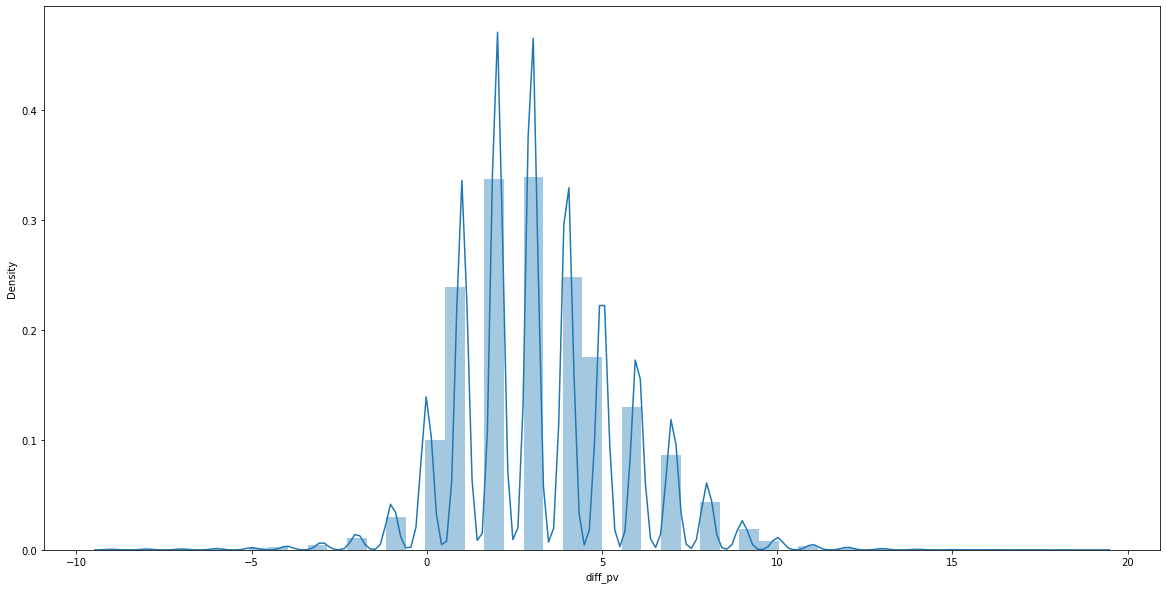

In [235]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.distplot(combine_data_2.query('order_date==1&cnt_product_id>20&diff_pv<20&diff_pv>-10')['diff_pv'])

In [ ]:
combine_data_2=(combine_data_2
               .merge(combine_data_2.query('diff_pv>0&order_date==1')
                                   .groupby('CreateByUser')['product_id'].count()
                                   .reset_index().rename(columns={'product_id':'cnt_pro_neg'})
                                  , on='CreateByUser', how='left')
               .merge(combine_data_2.query('type=="negative"&diff_rate>0.1')
                                   .groupby('CreateByUser')['product_id'].count()
                                   .reset_index().rename(columns={'product_id':'cnt_pro_neg_10percent'})
                                  , on='CreateByUser', how='left')
              )

In [ ]:
user: 12802

In [39]:
pv_product_id=(pv_product_id
 .merge(combine_data_2.groupby('product_id')['total_pageview'].agg({np.mean, np.median, max, min, np.std}).reset_index()
        , on = 'product_id', how='left')
)
# pv_product_id=(pv_product_id
#  .merge(combine_data_2.groupby('product_id')['total_pageview'].std().reset_index().rename(columns = {'total_pageview':'std'})
#         , on = 'product_id', how='left')
# )

In [93]:
pv_product_id.groupby('')['product_id'].count().head(10)

date
1      23306
2      47966
3      79762
4     109651
5     111910
6      97833
7      83114
8      77511
9      35079
10     33518
Name: product_id, dtype: int64

In [125]:
pv_product_id.query('std>5&diff_rate>0.5')

,product_id,VipType,usage_type,total_pageview,diff_pv,date,higher_ca,same,higher_ga,max,mean,median,min,std,diff_rate,type
442,8921591,5,Power User,22.0,13.0,3,2.0,1.0,NaN,18.0,7.333333,3.0,1.0,9.291573,0.590909,negative
761,9923725,5,Power User,23.0,15.0,3,3.0,NaN,NaN,14.0,7.666667,7.0,2.0,6.027714,0.652174,negative
2441,13817169,5,Power User,33.0,17.0,25,14.0,8.0,3.0,46.0,9.520000,2.0,1.0,13.435401,0.515152,negative
3106,14918714,5,Business,42.0,35.0,8,6.0,2.0,NaN,31.0,5.250000,1.0,1.0,10.457397,0.833333,negative
3181,14968968,5,Power User,13.0,7.0,3,1.0,2.0,NaN,11.0,4.333333,1.0,1.0,5.773503,0.538462,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971557,31631110,5,Frequent User,14.0,9.0,2,2.0,NaN,NaN,11.0,7.000000,7.0,3.0,5.656854,0.642857,negative
971633,31631194,5,Power User,1737.0,1727.0,2,2.0,NaN,NaN,1286.0,868.500000,868.5,451.0,590.434162,0.994243,negative
971728,31631295,5,Business,10.0,6.0,2,1.0,1.0,NaN,9.0,5.000000,5.0,1.0,5.656854,0.600000,negative
971743,31631311,5,Business,13.0,7.0,2,2.0,NaN,NaN,11.0,6.500000,6.5,2.0,6.363961,0.538462,negative


In [124]:
combine_data_2.query('product_id==31631194')

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
601824,2021-11-29,31631194,437.0,451.0,5.0,37.0,193205,5,None,Power User,-1,400.0,92.0,-1.0,446.0,99.0,1.0
948251,2021-11-30,31631194,1834.0,1286.0,5.0,388.0,193205,5,None,Power User,-1,1446.0,79.0,-1.0,1281.0,100.0,2.0


In [46]:
pv_product_id['diff_rate'] = pv_product_id['diff_pv']/pv_product_id['total_pageview']
pv_product_id['type'] = np.where(pv_product_id['diff_pv']>0, "negative",'positive' )

In [97]:
pv_product_id.groupby(['VipType','type'])['product_id'].count().unstack(level=0)

VipType,0,1,2,3,4,5,6
type,,,,,,,
negative,845,4255,2335,15583,1705,899775,5937
positive,737,3927,2649,9401,383,37302,241


In [136]:
pv_product_id.groupby(['VipType'])['total_pageview'].agg({np.mean, np.median}).reset_index()

,VipType,mean,median
0,0,463.545512,320.0
1,1,201.912735,131.0
2,2,142.368379,95.0
3,3,102.572486,70.0
4,4,150.936782,117.0
5,5,34.492146,22.0
6,6,31.894626,25.0


In [45]:
pv_product_id.head()

,product_id,VipType,usage_type,total_pageview,diff_pv,date,higher_ca,same,higher_ga,mean,max,median,min,std
0,2790817,5,Power User,90.0,34.0,36,23.0,11.0,2.0,2.500000,5.0,2.0,0.0,1.502379
1,2952646,5,Power User,221.0,31.0,45,19.0,22.0,4.0,4.911111,14.0,4.0,1.0,3.770834
2,2970795,5,Power User,198.0,22.0,36,19.0,12.0,5.0,5.500000,15.0,5.0,1.0,3.075247
3,3362630,5,Power User,86.0,17.0,26,12.0,13.0,1.0,3.307692,8.0,3.0,1.0,2.112235
4,3394417,5,Power User,89.0,8.0,36,17.0,14.0,5.0,2.472222,10.0,2.0,0.0,2.131212


In [44]:
pv_product_id.query('diff_>30').groupby('VipType').product_id.nunique()

VipType
0    1351
1    2524
2     738
3    1882
4     296
5    6442
6       5
Name: product_id, dtype: int64

In [104]:
pv_product_id.query('type=="negative"').groupby(['VipType','diff_pv'])['product_id'].count().unstack(level=0).head(20)

VipType,0,1,2,3,4,5,6
diff_pv,,,,,,,
1.0,30.0,352.0,240.0,1429.0,100.0,27914.0,305.0
2.0,29.0,331.0,244.0,1527.0,73.0,48554.0,510.0
3.0,38.0,327.0,227.0,1490.0,100.0,67601.0,526.0
4.0,29.0,325.0,218.0,1488.0,101.0,80680.0,548.0
5.0,23.0,330.0,193.0,1322.0,81.0,83968.0,552.0
6.0,24.0,272.0,204.0,1245.0,97.0,82722.0,519.0
7.0,17.0,271.0,169.0,1114.0,79.0,76399.0,557.0
8.0,19.0,227.0,131.0,940.0,92.0,69178.0,486.0
9.0,18.0,184.0,123.0,875.0,74.0,58722.0,460.0


In [49]:
pv_product_id.query('type=="negative"&diff_rate>0.2&std>10')

,product_id,VipType,usage_type,total_pageview,diff_pv,date,higher_ca,same,higher_ga,mean,max,median,min,std,diff_rate,type
597,9383263,5,Power User,94.0,19.0,41,19.0,12.0,10.0,13.121951,48.0,11.0,1.0,10.703259,0.202128,negative
2441,13817169,5,Power User,33.0,17.0,25,14.0,8.0,3.0,9.520000,46.0,2.0,1.0,13.435401,0.515152,negative
2561,14042648,5,Power User,20.0,8.0,16,8.0,5.0,3.0,16.187500,43.0,13.0,2.0,12.297527,0.400000,negative
3106,14918714,5,Business,42.0,35.0,8,6.0,2.0,NaN,5.250000,31.0,1.0,1.0,10.457397,0.833333,negative
3245,15042282,5,Power User,19.0,7.0,2,2.0,NaN,NaN,9.500000,18.0,9.5,1.0,12.020815,0.368421,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971474,31631020,3,Power User,28.0,9.0,2,2.0,NaN,NaN,14.000000,25.0,14.0,3.0,15.556349,0.321429,negative
971611,31631172,5,Frequent User,24.0,9.0,2,2.0,NaN,NaN,12.000000,22.0,12.0,2.0,14.142136,0.375000,negative
971633,31631194,5,Power User,1737.0,1727.0,2,2.0,NaN,NaN,868.500000,1286.0,868.5,451.0,590.434162,0.994243,negative
971791,31631366,5,Power User,2647.0,2636.0,2,2.0,NaN,NaN,1323.500000,2598.0,1323.5,49.0,1802.415185,0.995844,negative


In [133]:
pv_product_id.query('std>10&diff_rate>0.2').product_id.count()

1893

In [184]:
pv_product_id.query('VipType<=4&diff_rate>0.1').query('std>30')

,product_id,VipType,usage_type,total_pageview,diff_pv,date,higher_ca,same,higher_ga,max,mean,median,min,std,diff_rate,type
55822,28094702,0,Power User,555.0,59.0,9,8.0,1.0,NaN,130.0,61.666667,50.0,28.0,33.585711,0.106306,negative
66798,28654691,0,Casual User,690.0,430.0,36,15.0,14.0,7.0,276.0,21.166667,4.0,0.0,58.118844,0.623188,negative
78808,29001097,0,Frequent User,843.0,426.0,22,12.0,4.0,6.0,262.0,39.545455,12.0,1.0,69.920177,0.505338,negative
102937,29541072,0,Frequent User,825.0,441.0,43,19.0,10.0,14.0,265.0,27.558140,12.0,1.0,53.577404,0.534545,negative
104545,29570872,3,Business,68.0,8.0,15,6.0,5.0,4.0,181.0,45.533333,33.0,4.0,44.693986,0.117647,negative
129022,29923098,0,Power User,1330.0,417.0,23,8.0,1.0,14.0,318.0,81.478261,56.0,19.0,75.617981,0.313534,negative
170194,30357351,0,Power User,1355.0,374.0,24,12.0,1.0,11.0,303.0,82.125000,60.0,17.0,69.738214,0.276015,negative
176751,30412346,0,Business,859.0,423.0,11,5.0,1.0,5.0,266.0,78.090909,21.0,5.0,94.862484,0.492433,negative
198376,30574910,2,Power User,412.0,119.0,15,3.0,3.0,9.0,154.0,28.800000,21.0,0.0,37.556053,0.288835,negative
217357,30708218,0,Business,643.0,324.0,11,5.0,2.0,4.0,255.0,58.454545,14.0,3.0,91.156309,0.503888,negative


In [172]:
combine_data.query('user_id.notnull()').groupby('VipType')['product_id'].nunique()

VipType
0       67
1      275
2      223
3      808
5    29200
Name: product_id, dtype: int64

<AxesSubplot:xlabel='VipType', ylabel='std'>

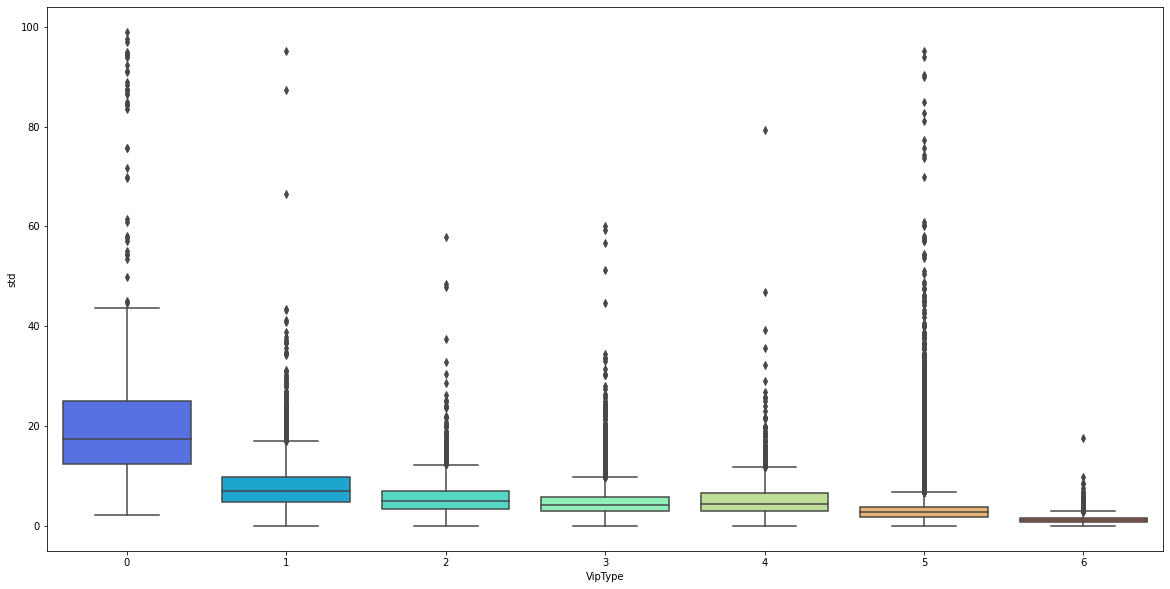

In [127]:
sns.boxplot(x='VipType',y='std',data=pv_product_id.query('type=="negative"&std<100'),palette='rainbow')

### Pageview daily

In [ ]:
combine_data_2.groupby(['VipType','order_date'])

In [142]:
combine_data_2.product_id.nunique()

974096

In [ ]:
sns.boxplot(x='VipType',y='std',data=combine_data_2.query('type=="negative"&std<100'),palette='rainbow')

In [141]:
combine_data_2.head()

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
0,2021-11-27,31235270,290.0,5.0,6.0,161.0,659497,5,None,Power User,-1,129.0,44.0,1.0,-1.0,-20.0,28.0
1,2021-10-18,30756413,54.0,1.0,3.0,43.0,1341113,2,None,Frequent User,-1,11.0,20.0,1.0,-2.0,-200.0,11.0
2,2021-11-03,31274154,308.0,28.0,23.0,466.0,803045,5,None,Power User,1,-158.0,-51.0,-1.0,5.0,18.0,1.0
3,2021-10-07,30443154,187.0,6.0,1.0,92.0,1515619,5,None,Power User,-1,95.0,51.0,-1.0,5.0,83.0,4.0
4,2021-11-10,31340106,152.0,7.0,8.0,463.0,1731074,3,None,Casual User,1,-311.0,-205.0,1.0,-1.0,-14.0,3.0


In [1]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_2.query('VipType==5&total_pageview<50'),palette='rainbow')

NameError: name 'sns' is not defined

In [266]:
combine_data_2.query('diff_pv>4&diff_rate_pv>10').product_id.nunique()

308530

In [280]:
combine_data_2.head()

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date,cnt_product_id
0,2021-10-08,30875170,668.0,17.0,21.0,484.0,1619857,2,None,Frequent User,-1,184.0,28.0,1.0,-4.0,-24.0,8.0,12.0
1,2021-10-26,31168378,236.0,7.0,5.0,179.0,582303,5,None,Power User,-1,57.0,24.0,-1.0,2.0,29.0,1.0,30.0
2,2021-10-17,31024484,101.0,6.0,7.0,95.0,1538651,5,None,Frequent User,-1,6.0,6.0,1.0,-1.0,-17.0,3.0,17.0
3,2021-10-19,30472454,133.0,10.0,9.0,48.0,1458248,5,None,Power User,-1,85.0,64.0,-1.0,1.0,10.0,9.0,64.0
4,2021-10-29,30848209,176.0,9.0,8.0,119.0,1705886,4,None,Casual User,-1,57.0,32.0,-1.0,1.0,11.0,2.0,1.0


In [271]:
combine_data_2.query('diff_pv>5')['product_id'].nunique()

187348

In [316]:
combine_data_2.query('diff_pv>2&order_date==1').product_id.nunique()

570689

In [307]:
(combine_data_2.query('diff_pv>5').groupby(['diff_pv','product_id','CreateByUser'])['date'].nunique().reset_index()
 ['CreateByUser'].nunique()
 
)

41985

In [312]:
(combine_data_2.query('diff_pv>5').groupby(['product_id','CreateByUser'])['date'].nunique().reset_index()
 .groupby(['date'])['CreateByUser'].nunique()
 
)

date
1     41012
2      3906
3       575
4       251
5       115
6        57
7        47
8        34
9        19
10       17
11       15
12       13
13        7
14        7
15        4
16        3
17        2
18        1
Name: CreateByUser, dtype: int64

In [303]:
(combine_data_2.query('diff_pv>5').groupby(['product_id','CreateByUser'])['date'].nunique().reset_index()
 .groupby(['date'])['CreateByUser'].nunique().reset_index()
 
)

,date,CreateByUser
0,1,41012
1,2,3906
2,3,575
3,4,251
4,5,115
5,6,57
6,7,47
7,8,34
8,9,19
9,10,17


In [ ]:
combine_data_2.c

In [267]:
combine_data_2.query('diff_pv>3&diff_rate_pv>0.3')

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date,cnt_product_id
5,2021-11-30,31635756,94.0,7.0,3.0,54.0,99923,5,None,Power User,-1,40.0,43.0,-1.0,4.0,57.0,1.0,47.0
10,2021-10-14,31024167,208.0,18.0,11.0,128.0,1466946,5,None,Business,-1,80.0,38.0,-1.0,7.0,39.0,1.0,515.0
12,2021-11-26,31488127,98.0,11.0,7.0,42.0,239250,5,None,Power User,-1,56.0,57.0,-1.0,4.0,36.0,9.0,66.0
13,2021-11-30,20814308,104.0,5.0,1.0,221.0,932457,5,None,Business,1,-117.0,-113.0,-1.0,4.0,80.0,34.0,131.0
14,2021-10-18,24675824,160.0,5.0,1.0,93.0,1329285,5,None,Business,-1,67.0,42.0,-1.0,4.0,80.0,1.0,158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14582709,2021-11-03,31277905,56.0,8.0,2.0,13.0,660034,5,None,Power User,-1,43.0,77.0,-1.0,6.0,75.0,1.0,36.0
14582720,2021-11-03,31272888,72.0,8.0,2.0,39.0,1377524,5,None,Business,-1,33.0,46.0,-1.0,6.0,75.0,1.0,46.0
14582725,2021-10-14,31029616,70.0,8.0,2.0,15.0,1628244,5,None,Power User,-1,55.0,79.0,-1.0,6.0,75.0,1.0,92.0
14582727,2021-11-22,31534037,89.0,8.0,2.0,72.0,1732111,5,None,Frequent User,-1,17.0,19.0,-1.0,6.0,75.0,1.0,10.0


In [259]:
combine_data_2.query('diff_pv>5').product_id.nunique()

187348

In [20]:
# combine_data_3.total_pageview.mean()
combine_data_3[['total_pageview']].quantile(q=[0.25, 0.5, 0.75, 0.9, 0.99])

,total_pageview
0.25,1.0
0.50,1.0
0.75,2.0
0.90,4.0
0.99,10.0


<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

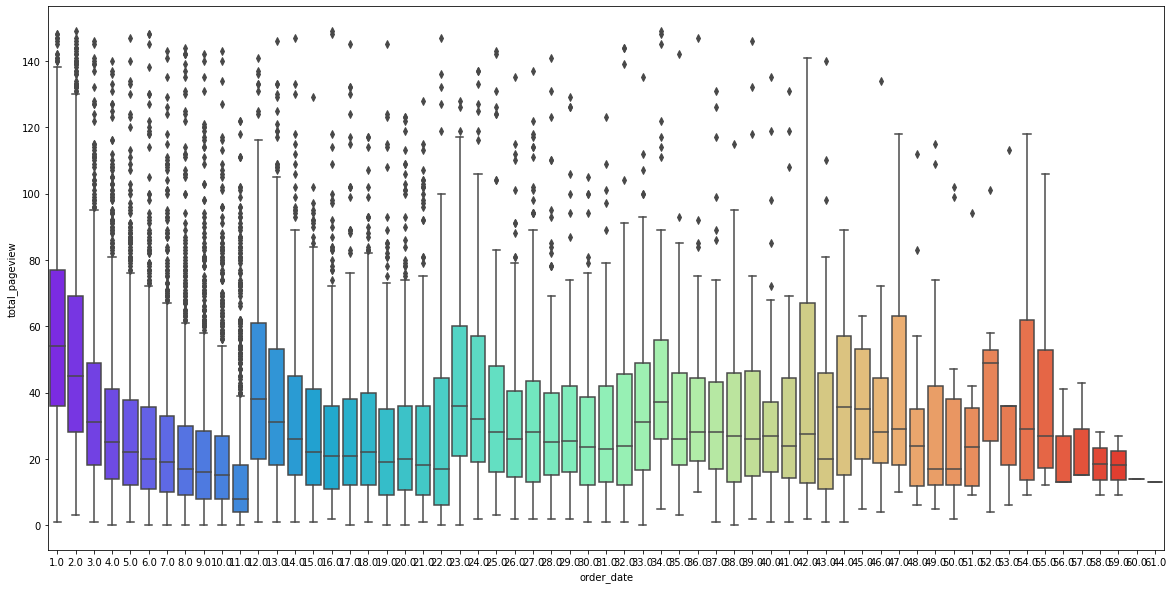

In [250]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_2.query('VipType==0&total_pageview<150'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

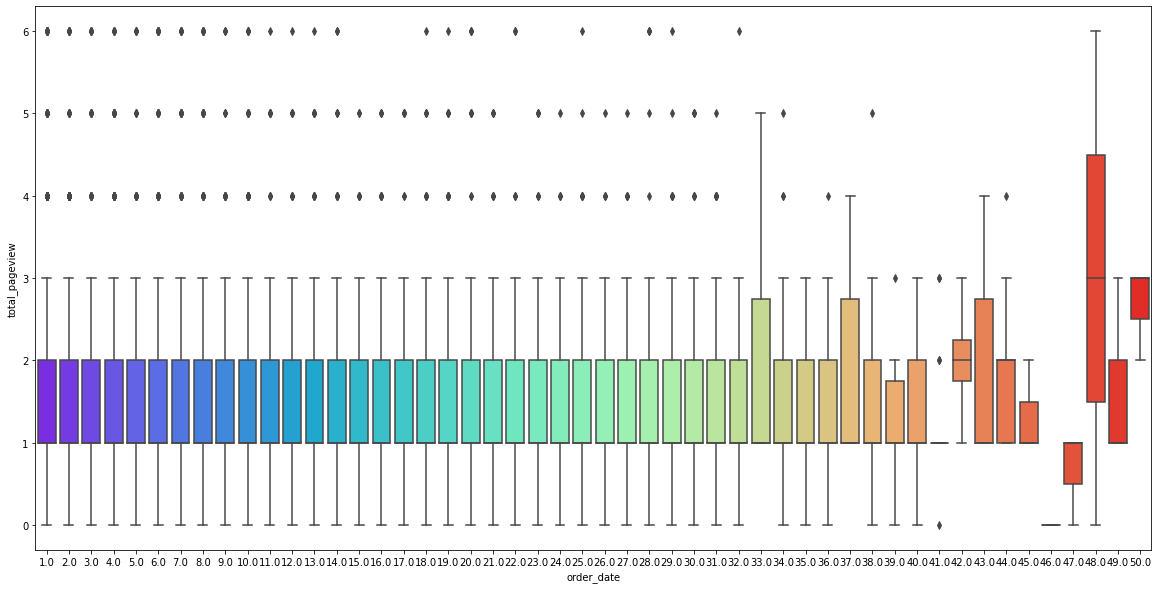

In [253]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_3.query('VipType==0&total_pageview<7'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

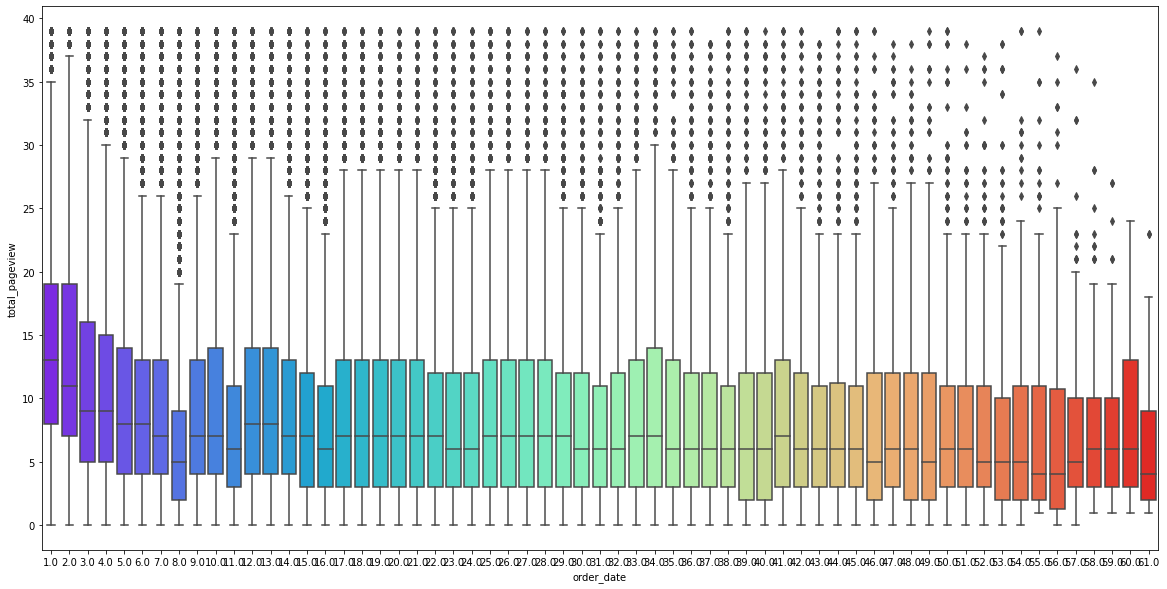

In [241]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_2.query('VipType<5&total_pageview<40'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

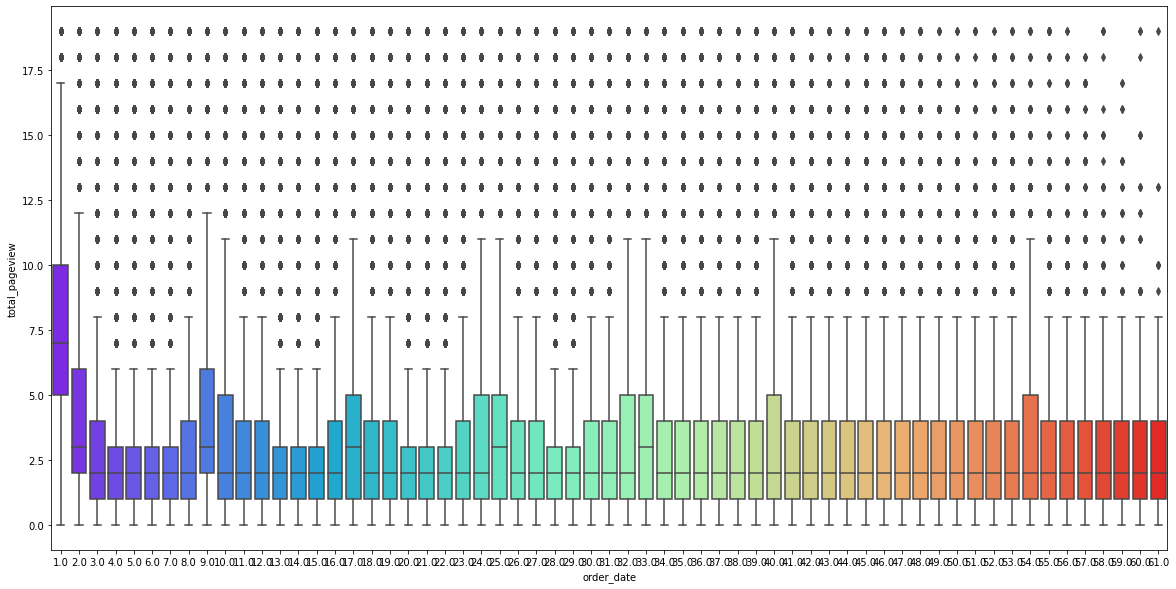

In [243]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_2.query('VipType>=5&total_pageview<20'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

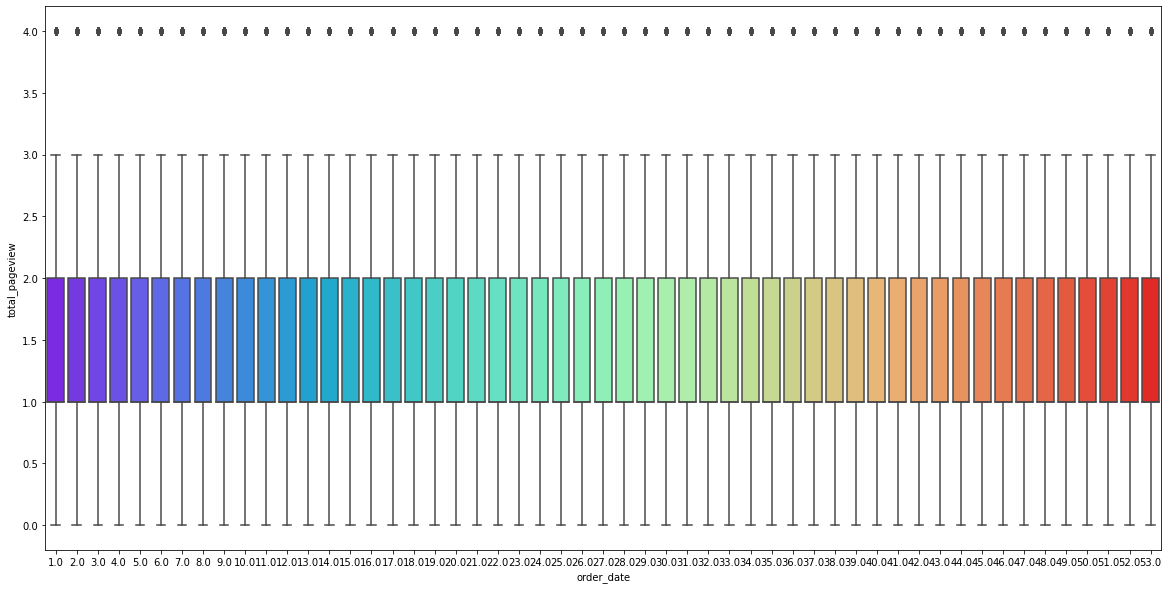

In [256]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_3.query('VipType>=5&total_pageview<5'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

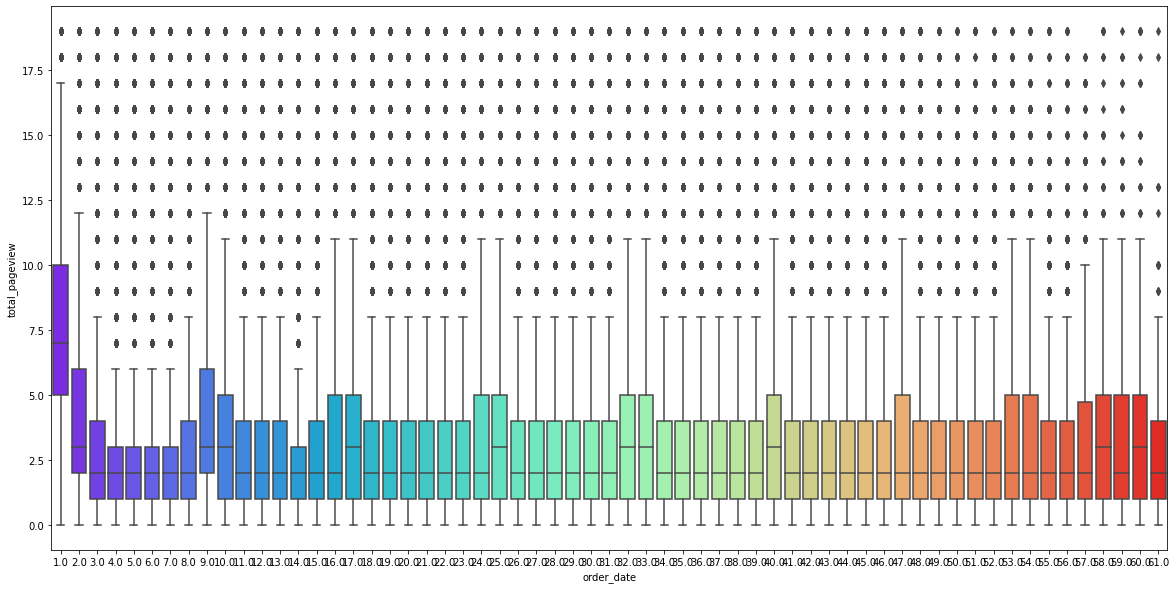

In [244]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_2.query('total_pageview<20'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='diff_pv'>

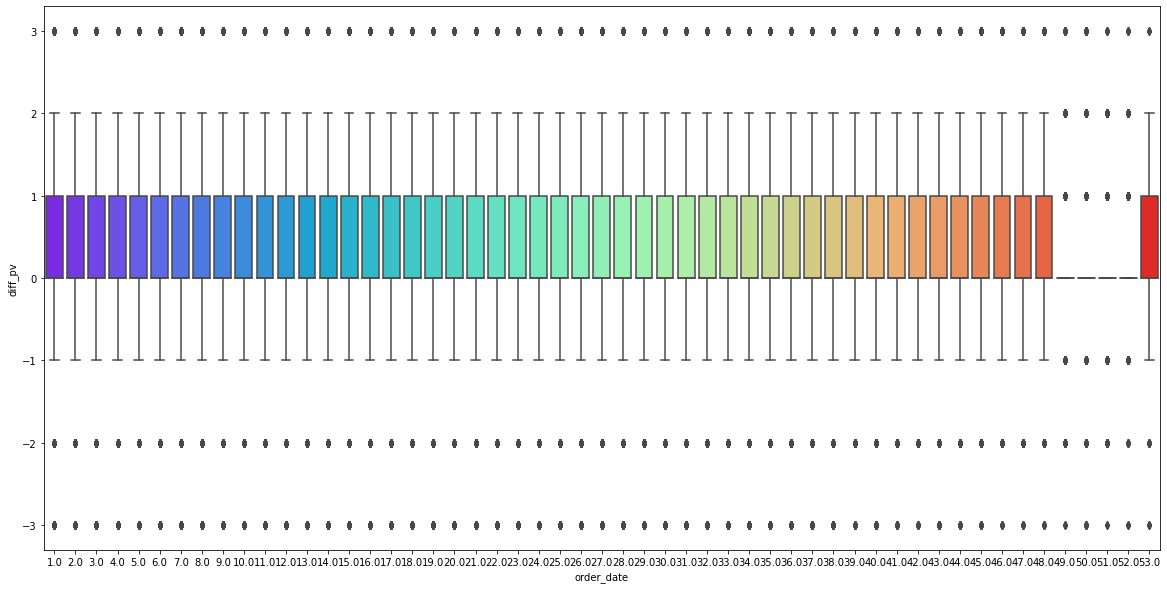

In [214]:
plt.rcParams['figure.figsize'] = (20.0, 10)
sns.boxplot(x='order_date',y='diff_pv',data=combine_data_3.query('diff_pv<4&diff_pv>-4'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

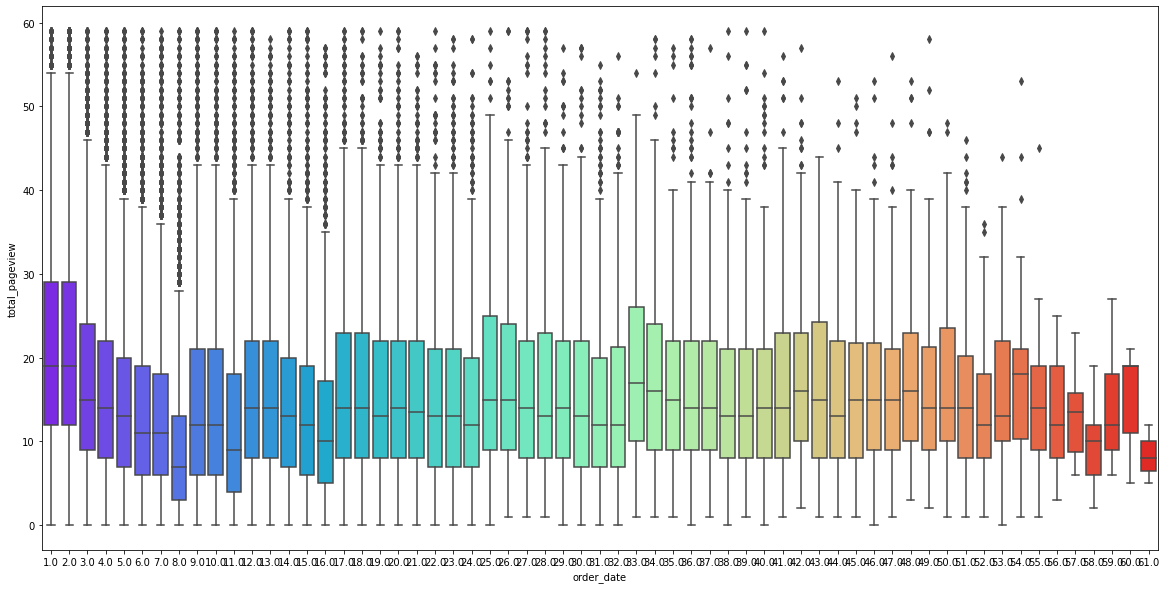

In [177]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_2.query('VipType==1&total_pageview<60'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

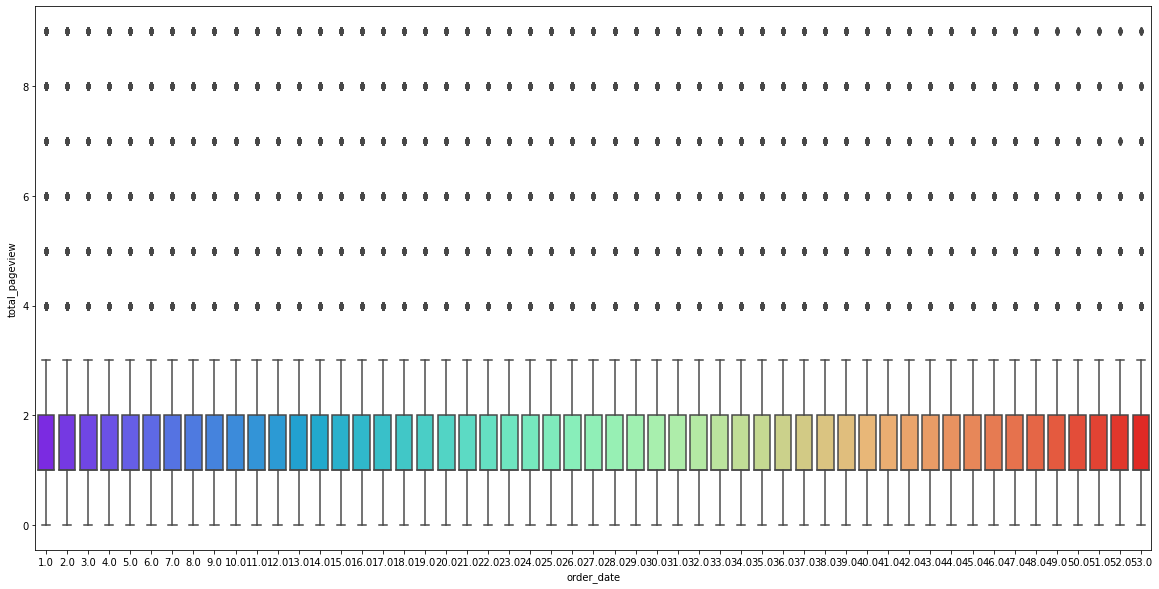

In [180]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_3.query('VipType>2&total_pageview<10'),palette='rainbow')

In [230]:
combine_data_2['diff_pv_type']=np.where(combine_data_2['diff_pv_type']>5, 6,combine_data_2['diff_pv_type'] )
combine_data_3['diff_pv_type']=np.where(combine_data_3['diff_pv_type']>5, 6,combine_data_3['diff_pv_type'] )
# combine_data_2['diff_pv_type']=np.where(combine_data_2['diff_pv_type']<=0, 0,combine_data_2['diff_pv_type'] )
# combine_data_3['diff_pv_type']=np.where(combine_data_3['diff_pv_type']<=0, 0,combine_data_3['diff_pv_type'] )

In [229]:
combine_data_2.query('diff_pv_type>6')

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date,diff_pv_type
37,2021-11-08,31340429,192.0,17.0,8.0,78.0,1553393,5,None,Power User,-1,114.0,59.0,-1.0,9.0,53.0,1.0,9.0
39,2021-11-10,30617212,68.0,11.0,4.0,37.0,1432704,5,None,Business,-1,31.0,46.0,-1.0,7.0,64.0,1.0,7.0
60,2021-11-05,30571253,473.0,14.0,5.0,106.0,1572052,5,None,Business,-1,367.0,78.0,-1.0,9.0,64.0,2.0,9.0
98,2021-11-16,31450516,159.0,11.0,4.0,43.0,1385958,5,None,Business,-1,116.0,73.0,-1.0,7.0,64.0,1.0,7.0
109,2021-10-12,30986320,207.0,13.0,1.0,90.0,1477863,5,None,Frequent User,-1,117.0,57.0,-1.0,12.0,92.0,1.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14522890,2021-11-02,31263821,186.0,12.0,3.0,75.0,1134862,5,None,Power User,-1,111.0,60.0,-1.0,9.0,75.0,1.0,9.0
14522916,2021-10-28,31196164,184.0,12.0,3.0,115.0,467193,5,None,Power User,-1,69.0,38.0,-1.0,9.0,75.0,1.0,9.0
14522929,2021-11-05,30040693,274.0,12.0,3.0,144.0,1608547,5,None,Power User,-1,130.0,47.0,-1.0,9.0,75.0,9.0,9.0
14523200,2021-11-02,31262034,174.0,12.0,3.0,272.0,463797,5,None,Power User,1,-98.0,-56.0,-1.0,9.0,75.0,1.0,9.0


In [239]:
combine_data_3.groupby(['order_date','diff_pv_type'])['product_id'].count().unstack(level=1).reset_index().head(60)

diff_pv_type,order_date,0.0,1.0,2.0,3.0,4.0,5.0,6.0
0,1.0,122654.0,85069.0,23593.0,7044.0,1849.0,545.0,477.0
1,2.0,106382.0,76653.0,19648.0,3714.0,954.0,315.0,564.0
2,3.0,100387.0,64970.0,14155.0,2563.0,747.0,289.0,524.0
3,4.0,90650.0,61456.0,14469.0,3117.0,887.0,332.0,474.0
4,5.0,84174.0,52522.0,10917.0,2178.0,661.0,194.0,494.0
5,6.0,74324.0,48506.0,11158.0,2377.0,664.0,203.0,500.0
6,7.0,69795.0,41745.0,9228.0,2317.0,695.0,211.0,549.0
7,8.0,65752.0,35141.0,6208.0,1162.0,376.0,161.0,499.0
8,9.0,62872.0,30462.0,5159.0,1050.0,297.0,139.0,367.0
9,10.0,58135.0,28449.0,4583.0,958.0,302.0,144.0,352.0


<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

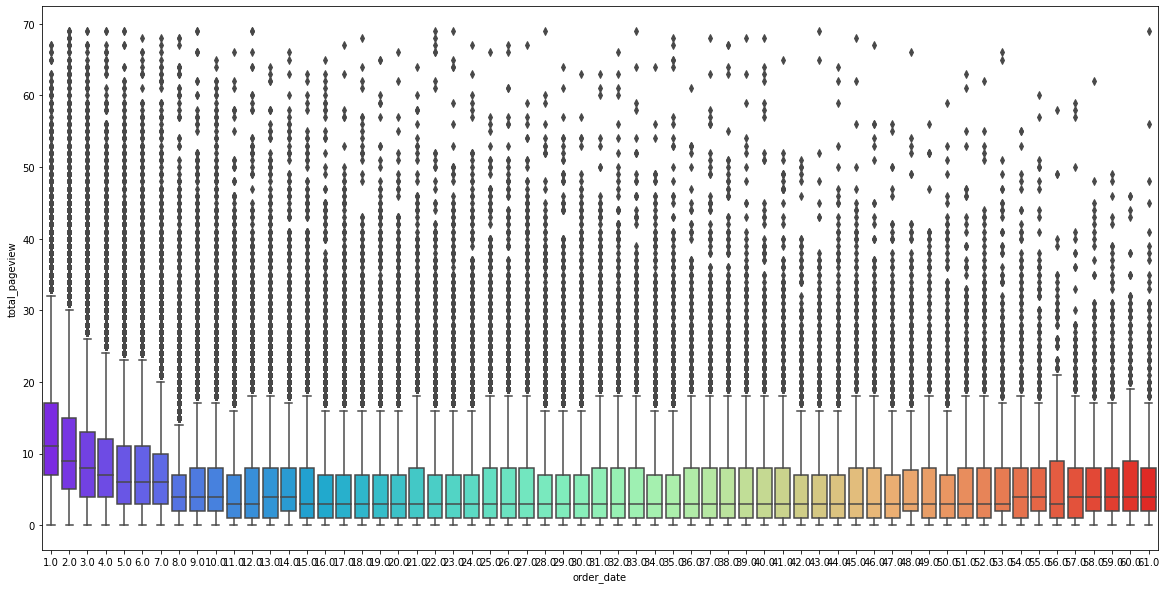

In [146]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data.query('VipType==3&total_pageview<70'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

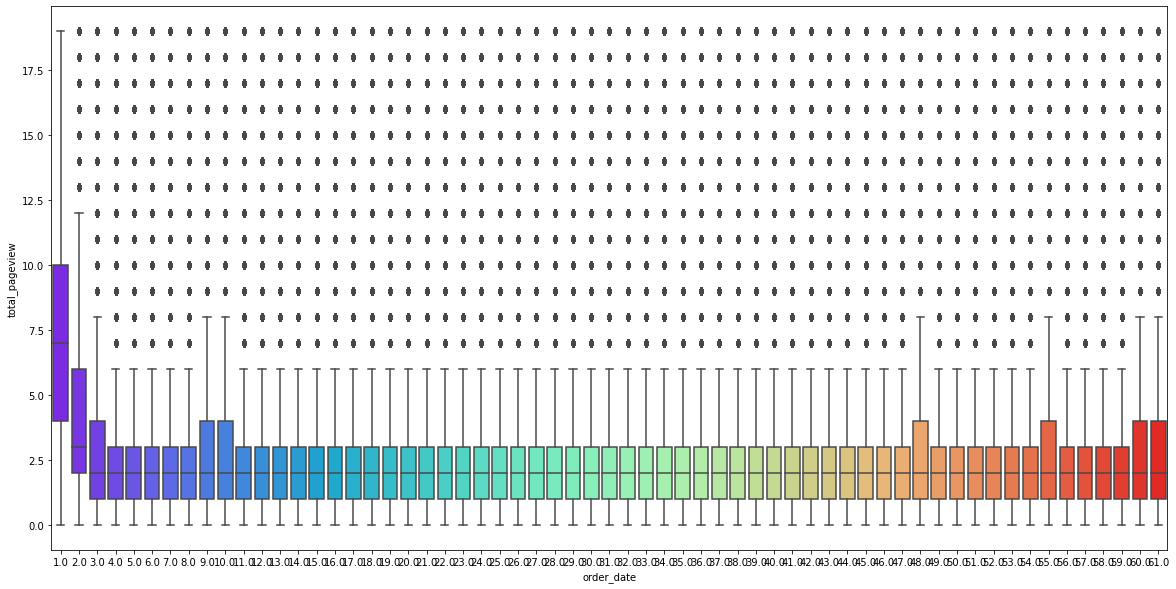

In [150]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data.query('VipType>4&total_pageview<20'),palette='rainbow')

### user view statistics:

In [92]:
combine_data_2[combine_data_2.user_id.notnull()].groupby('usage_type')['CreateByUser'].nunique()

usage_type
Business          491
Casual User       413
Frequent User    1135
Power User        408
Trial             216
Name: CreateByUser, dtype: int64

In [93]:
combine_data_2.groupby('usage_type')['CreateByUser'].nunique()

usage_type
Business         13772
Casual User      10980
Frequent User    25519
Power User       18697
Trial            10731
Name: CreateByUser, dtype: int64

In [95]:
(combine_data_2.groupby('usage_type')['product_id'].nunique().reset_index()
 .merge(combine_data_2[combine_data_2.user_id.notnull()].groupby('usage_type')['product_id'].nunique().reset_index(),
       on='usage_type', how='left')
)

,usage_type,product_id_x,product_id_y
0,Business,359265,13480
1,Casual User,16045,645
2,Frequent User,148272,9642
3,Power User,430112,13201
4,Trial,20573,712


In [96]:
(combine_data_2.groupby('usage_type')['CreateByUser'].nunique().reset_index()
 .merge(combine_data_2[combine_data_2.user_id.notnull()].groupby('usage_type')['CreateByUser'].nunique().reset_index(),
       on='usage_type', how='left')
)

,usage_type,CreateByUser_x,CreateByUser_y
0,Business,13772,491
1,Casual User,10980,413
2,Frequent User,25519,1135
3,Power User,18697,408
4,Trial,10731,216


In [91]:
combine_data_2.head()

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
0,2021-10-08,30875170,668.0,17.0,21.0,484.0,1619857,2,None,Frequent User,-1,184.0,28.0,1.0,-4.0,-24.0,8.0
1,2021-10-26,31168378,236.0,7.0,5.0,179.0,582303,5,None,Power User,-1,57.0,24.0,-1.0,2.0,29.0,1.0
2,2021-10-17,31024484,101.0,6.0,7.0,95.0,1538651,5,None,Frequent User,-1,6.0,6.0,1.0,-1.0,-17.0,3.0
3,2021-10-19,30472454,133.0,10.0,9.0,48.0,1458248,5,None,Power User,-1,85.0,64.0,-1.0,1.0,10.0,9.0
4,2021-10-29,30848209,176.0,9.0,8.0,119.0,1705886,4,None,Casual User,-1,57.0,32.0,-1.0,1.0,11.0,2.0


In [90]:
combine_data_2['CreateByUser'].nunique()

79699

In [84]:
(combine_data_2.groupby('VipType')['product_id'].nunique().reset_index()
 .merge(combine_data_2[combine_data_2.user_id.notnull()].groupby('VipType')['product_id'].nunique().reset_index(),
       on='VipType', how='left')
)

,VipType,product_id_x,product_id_y
0,0,1582,82.0
1,1,8185,328.0
2,2,4986,276.0
3,3,24994,1045.0
4,4,2088,80.0
5,5,937085,36475.0
6,6,6181,NaN


In [87]:
combine_data_2.head()

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
0,2021-10-08,30875170,668.0,17.0,21.0,484.0,1619857,2,None,Frequent User,-1,184.0,28.0,1.0,-4.0,-24.0,8.0
1,2021-10-26,31168378,236.0,7.0,5.0,179.0,582303,5,None,Power User,-1,57.0,24.0,-1.0,2.0,29.0,1.0
2,2021-10-17,31024484,101.0,6.0,7.0,95.0,1538651,5,None,Frequent User,-1,6.0,6.0,1.0,-1.0,-17.0,3.0
3,2021-10-19,30472454,133.0,10.0,9.0,48.0,1458248,5,None,Power User,-1,85.0,64.0,-1.0,1.0,10.0,9.0
4,2021-10-29,30848209,176.0,9.0,8.0,119.0,1705886,4,None,Casual User,-1,57.0,32.0,-1.0,1.0,11.0,2.0


In [34]:
combine_data_2.query('diff_pv>10').groupby('diff_rate_pv')['product_id'].count().head(30)

diff_rate_pv
3.0      1
5.0      3
7.0      2
8.0      7
9.0     10
10.0    17
11.0    12
12.0    15
13.0    20
14.0    21
15.0    39
16.0    45
17.0    25
18.0    35
19.0    25
20.0    34
21.0    35
22.0    49
23.0    41
24.0    33
25.0    37
26.0    32
27.0    36
28.0    26
29.0    35
30.0    34
31.0    53
32.0    45
33.0    51
34.0    43
Name: product_id, dtype: int64

In [36]:
combine_data_2.head()

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
0,2021-10-08,30875170,668.0,17.0,21.0,484.0,1619857,2,None,Frequent User,-1,184.0,28.0,1.0,-4.0,-24.0,8.0
1,2021-10-26,31168378,236.0,7.0,5.0,179.0,582303,5,None,Power User,-1,57.0,24.0,-1.0,2.0,29.0,1.0
2,2021-10-17,31024484,101.0,6.0,7.0,95.0,1538651,5,None,Frequent User,-1,6.0,6.0,1.0,-1.0,-17.0,3.0
3,2021-10-19,30472454,133.0,10.0,9.0,48.0,1458248,5,None,Power User,-1,85.0,64.0,-1.0,1.0,10.0,9.0
4,2021-10-29,30848209,176.0,9.0,8.0,119.0,1705886,4,None,Casual User,-1,57.0,32.0,-1.0,1.0,11.0,2.0


In [37]:
pv_product_id.query('max-min>30')

NameError: name 'pv_product_id' is not defined

## Impression

### Số impression mỗi ngày 

<AxesSubplot:xlabel='order_date', ylabel='total_impression'>

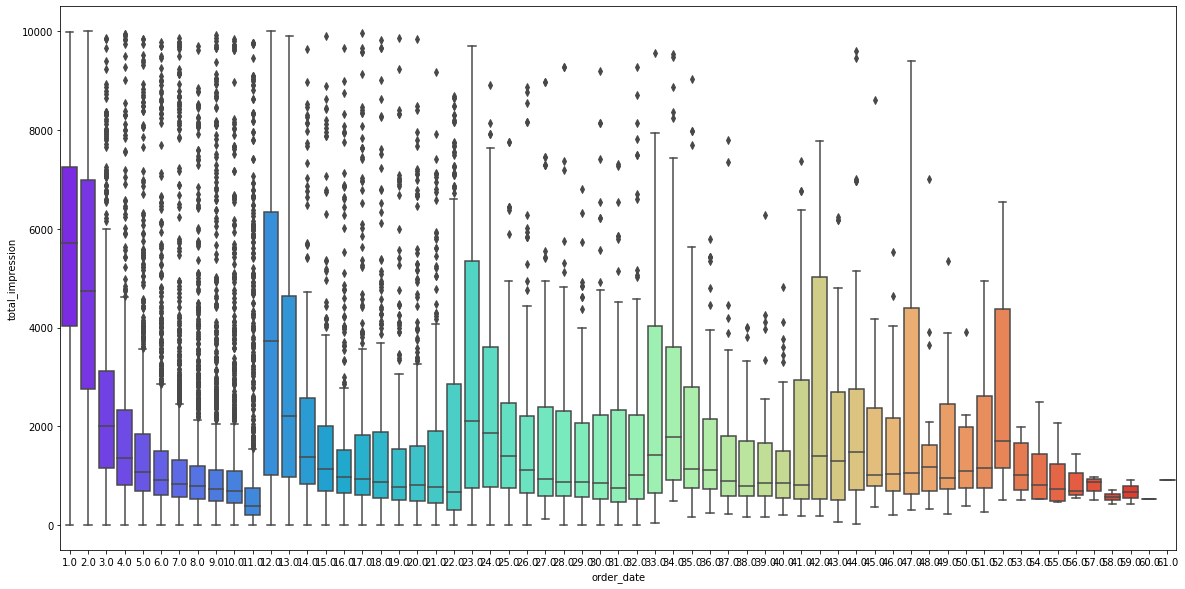

In [61]:
sns.boxplot(x='order_date',y='total_impression',data=combine_data_2.query('VipType==0&total_impression<10000'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_impression'>

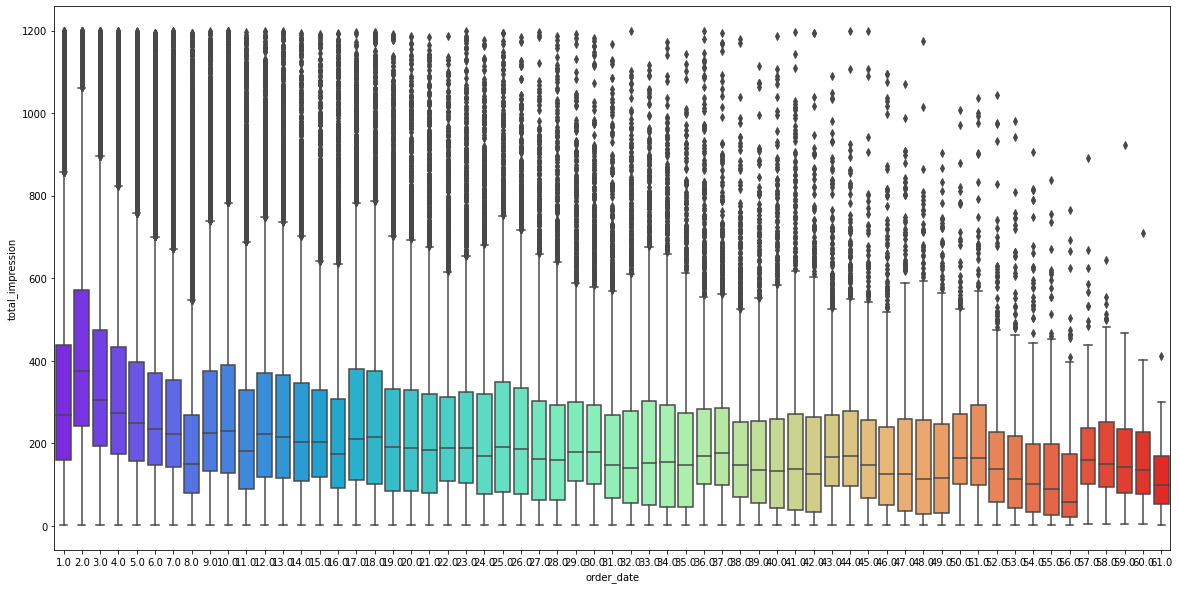

In [69]:
sns.boxplot(x='order_date',y='total_impression',data=combine_data_2.query('VipType>0&VipType<5&total_impression<1200'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_impression'>

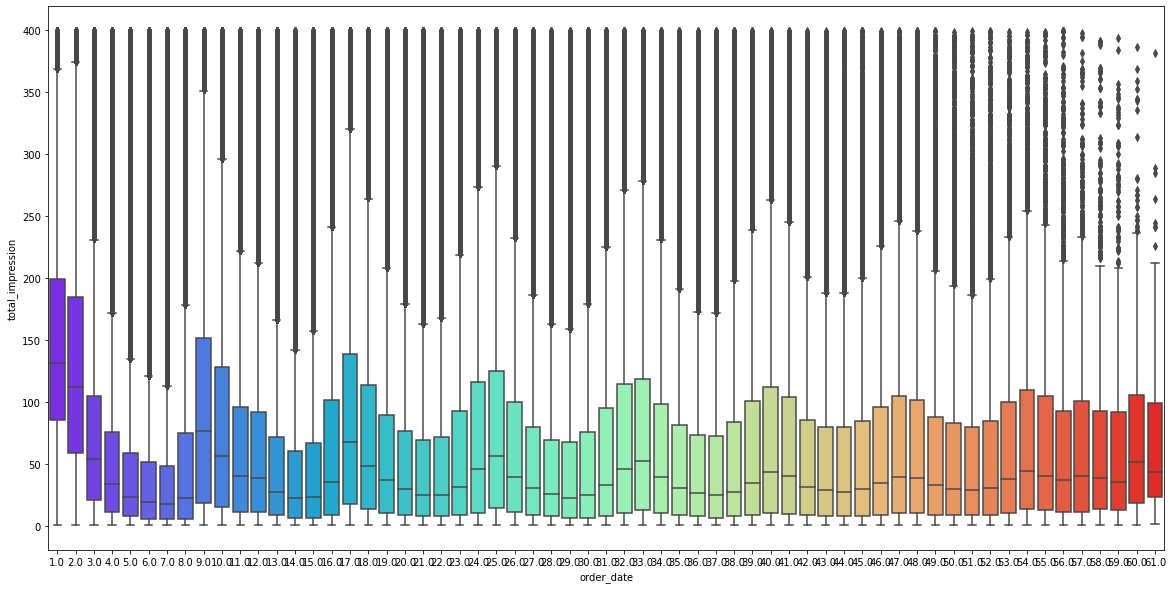

In [72]:
sns.boxplot(x='order_date',y='total_impression',data=combine_data_2.query('VipType==5&total_impression<400'),palette='rainbow')

## Impression trong thời gian tin đăng hết hạn
* Không có sự khác biệt nhiều giữa tin thường hay tin vip, mỗi ngày mỗi listing có dưới 50 impression, 75% dưới 20 impression

In [127]:
pv_product_id.query('diff_rate>0.2&diff_pv>5').product_id.nunique()

493856

In [139]:
pv_product_id=(pv_product_id
 .merge(combine_data_2[['product_id','CreateByUser']].drop_duplicates(), on='product_id', how='left')
              )

In [143]:
user = (pv_product_id
 .groupby('CreateByUser')['product_id'].count().reset_index()
 .merge(pv_product_id.groupby('CreateByUser')['total_pageview','diff_pv'].sum().reset_index(), on='CreateByUser', how='inner')
)

<ipython-input-143-adae4da963a1>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  .merge(pv_product_id.groupby('CreateByUser')['total_pageview','diff_pv'].sum().reset_index(), on='CreateByUser', how='inner')


In [144]:
user['type']=np.where(user['diff_pv']<=0,'positive','negative')

In [161]:
user=user.rename(columns = {'product_id':'cnt_product_id'})

In [160]:
user.head()

,CreateByUser,product_id,total_pageview,diff_pv,type,diff_rate
0,141,3,173.0,19.0,negative,0.109827
1,159,2,71.0,22.0,negative,0.309859
2,162,1,96.0,-3.0,positive,-0.031250
3,169,1,45.0,7.0,negative,0.155556
4,198,2,61.0,15.0,negative,0.245902


In [164]:
pv_product_id=pv_product_id.merge(user[['CreateByUser','cnt_product_id']], on='CreateByUser', how='left')

In [170]:
combine_data_2=combine_data_2.merge(user[['CreateByUser','cnt_product_id']], on='CreateByUser', how='left')

In [163]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.distplot(pv_product_id.query('cnt_product_id>10')['diff_pv'])
# pv_product_id.query('cnt_product_id>10').

UndefinedVariableError: name 'cnt_product_id' is not defined

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff_pv', ylabel='Density'>

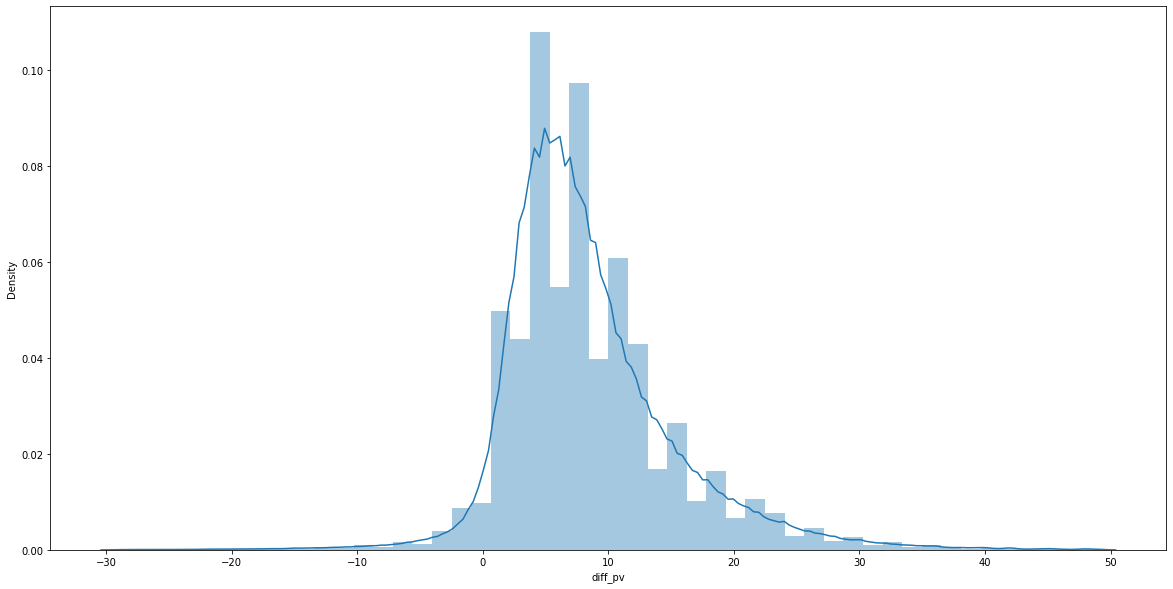

In [172]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.distplot(pv_product_id.query('cnt_product_id>20&diff_pv<50&diff_pv>-30')['diff_pv'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff_pv', ylabel='Density'>

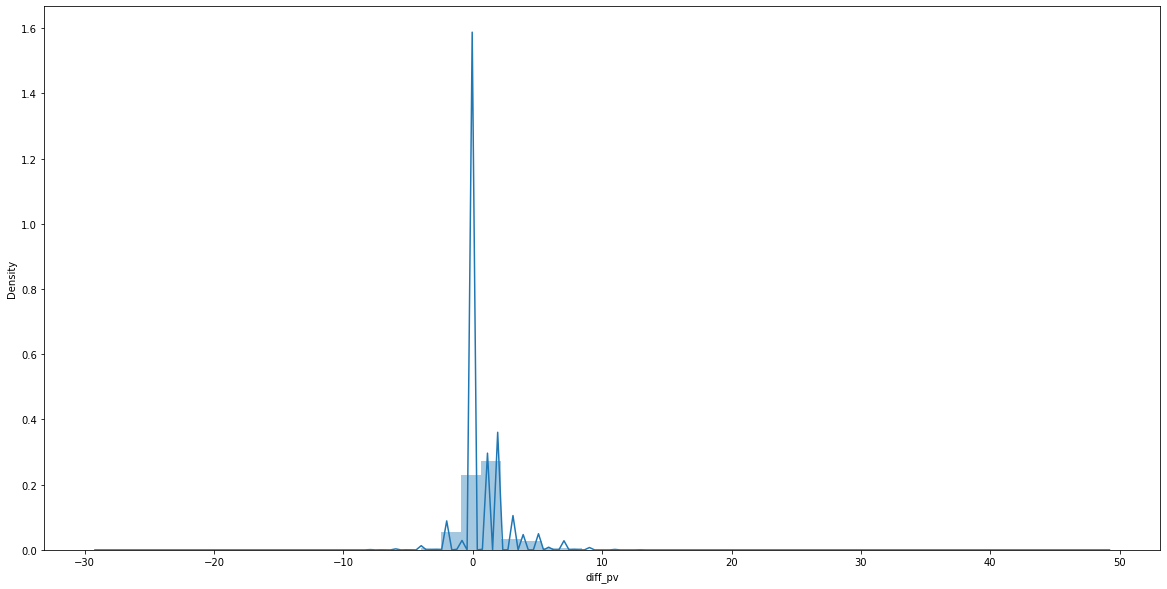

In [171]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.distplot(combine_data_2.query('cnt_product_id>10&diff_pv<50&diff_pv>-30')['diff_pv'])

In [146]:
user['diff_rate']=user['diff_pv']/user['total_pageview']

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff_pv', ylabel='Density'>

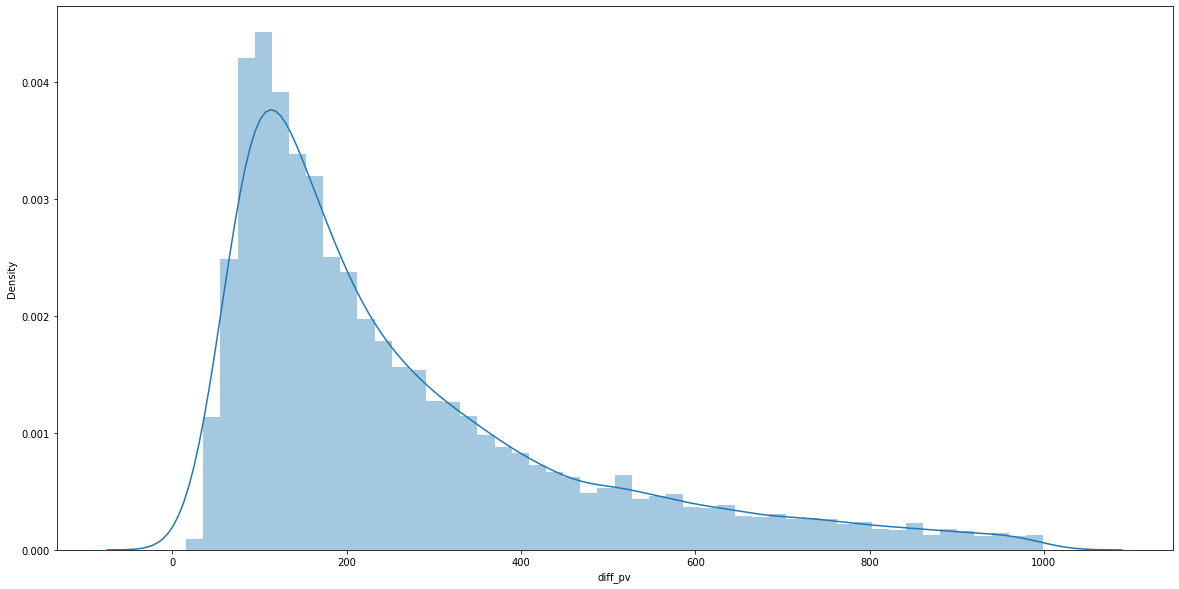

In [154]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.distplot(user.query('product_id>10&diff_rate>0.2&diff_pv<1000')['diff_pv']/)

In [140]:
pv_product_id.head()

,product_id,VipType,usage_type,total_pageview,diff_pv,date,higher_ca,same,higher_ga,mean,max,median,min,std,diff_rate,type,CreateByUser
0,2790817,5,Power User,90.0,34.0,36,23.0,11.0,2.0,2.500000,5.0,2.0,0.0,1.502379,0.377778,negative,387
1,2952646,5,Power User,221.0,31.0,45,19.0,22.0,4.0,4.911111,14.0,4.0,1.0,3.770834,0.140271,negative,163639
2,2970795,5,Power User,198.0,22.0,36,19.0,12.0,5.0,5.500000,15.0,5.0,1.0,3.075247,0.111111,negative,3870
3,3362630,5,Power User,86.0,17.0,26,12.0,13.0,1.0,3.307692,8.0,3.0,1.0,2.112235,0.197674,negative,59075
4,3394417,5,Power User,89.0,8.0,36,17.0,14.0,5.0,2.472222,10.0,2.0,0.0,2.131212,0.089888,negative,59075


In [134]:
combine_data_2.query('diff_rate_pv>0.2&diff_pv>5&order_date<=1').groupby('VipType').CreateByUser.nunique()

VipType
0      541
1     1561
2      709
3     3368
4      355
5    35684
6        4
Name: CreateByUser, dtype: int64

In [132]:
combine_data_2.query('order_date<=1').CreateByUser.nunique()

974096

In [128]:
combine_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14582747 entries, 0 to 14582746
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   product_id        int64         
 2   total_impression  float64       
 3   total_pageview    float64       
 4   ga_pageviews      float64       
 5   ga_impression     float64       
 6   CreateByUser      int64         
 7   VipType           int64         
 8   user_id           object        
 9   usage_type        object        
 10  higher_ga_imp     int64         
 11  diff_imp          float64       
 12  diff_rate_imp     float64       
 13  higher_ga_pv      float64       
 14  diff_pv           float64       
 15  diff_rate_pv      float64       
 16  order_date        float64       
dtypes: datetime64[ns](1), float64(10), int64(4), object(2)
memory usage: 1.8+ GB


In [125]:
pv_product_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985075 entries, 0 to 985074
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   product_id      985075 non-null  int64  
 1   VipType         985075 non-null  int64  
 2   usage_type      985075 non-null  object 
 3   total_pageview  985075 non-null  float64
 4   diff_pv         985075 non-null  float64
 5   date            985075 non-null  int64  
 6   higher_ca       979792 non-null  float64
 7   same            835751 non-null  float64
 8   higher_ga       456024 non-null  float64
 9   mean            985075 non-null  float64
 10  max             985075 non-null  float64
 11  median          985075 non-null  float64
 12  min             985075 non-null  float64
 13  std             961804 non-null  float64
 14  diff_rate       985075 non-null  float64
 15  type            985075 non-null  object 
dtypes: float64(11), int64(3), object(2)
memory usage: 127.8+

<AxesSubplot:xlabel='order_date', ylabel='total_impression'>

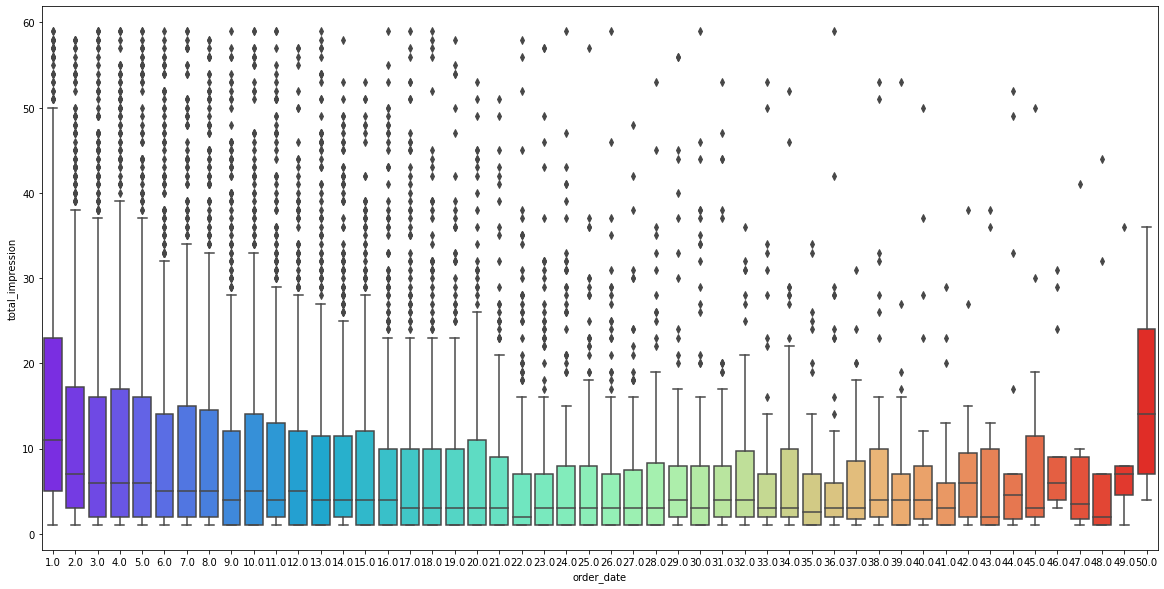

In [76]:
sns.boxplot(x='order_date',y='total_impression',data=combine_data_3.query('VipType==0&total_impression<60'),palette='rainbow')

### Chênh lệch impression 

<AxesSubplot:xlabel='order_date', ylabel='diff_imp'>

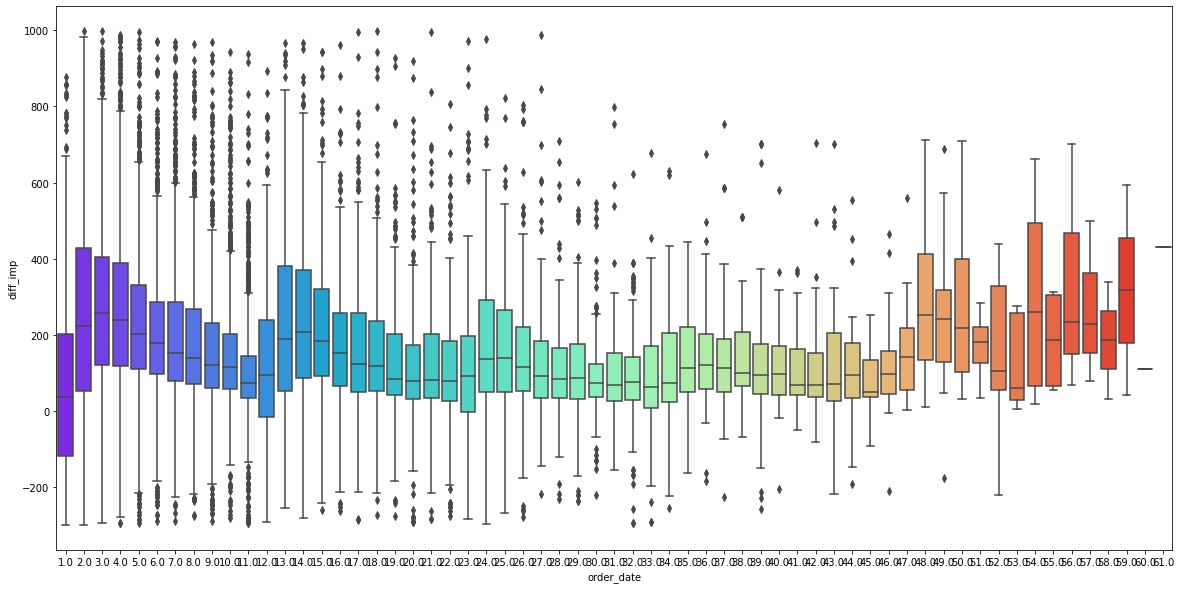

In [109]:
sns.boxplot(x='order_date',y='diff_imp',data=combine_data_2.query('VipType==0&diff_imp<1000&diff_imp>-300'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='diff_imp'>

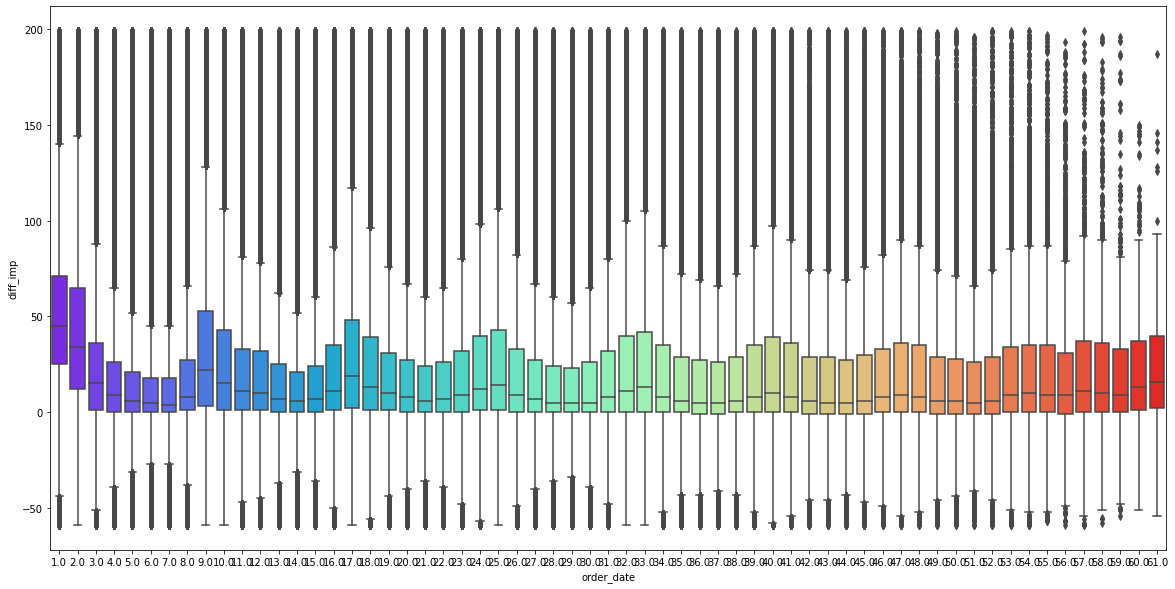

In [113]:
sns.boxplot(x='order_date',y='diff_imp',data=combine_data_2.query('VipType>0&diff_imp<200&diff_imp>-60'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='diff_rate_imp'>

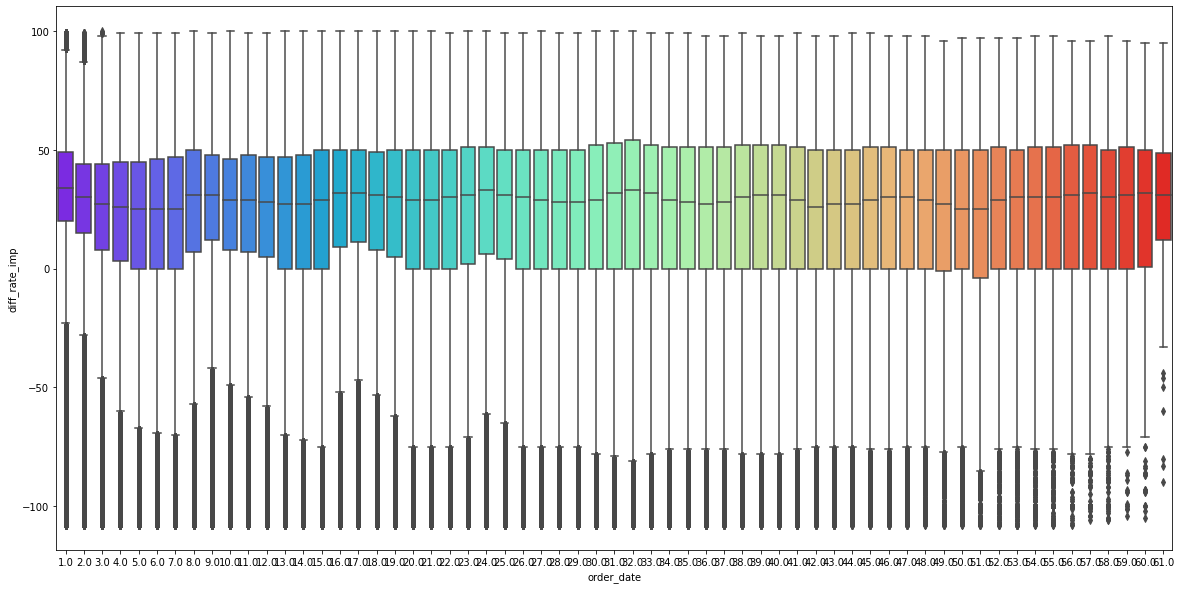

In [117]:
sns.boxplot(x='order_date',y='diff_rate_imp',data=combine_data_2.query('VipType=0&diff_rate_imp<999&diff_rate_imp>-109'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='diff_rate_imp'>

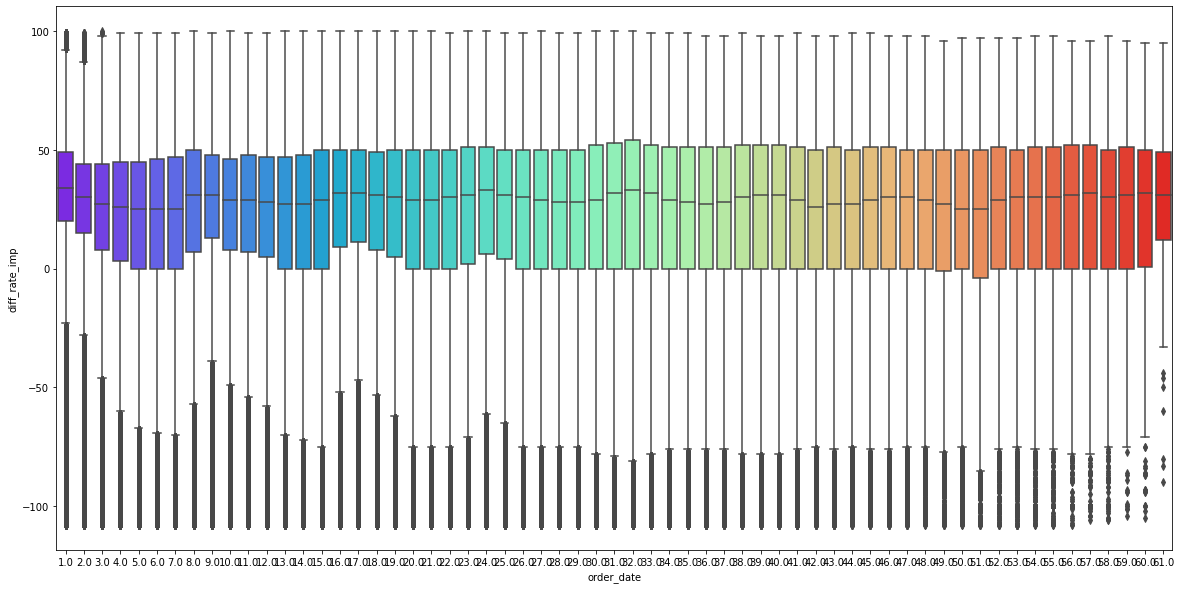

In [122]:
sns.boxplot(x='order_date',y='diff_rate_imp',data=combine_data_2.query('VipType>0&diff_rate_imp<999&diff_rate_imp>-109'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='diff_rate_imp'>

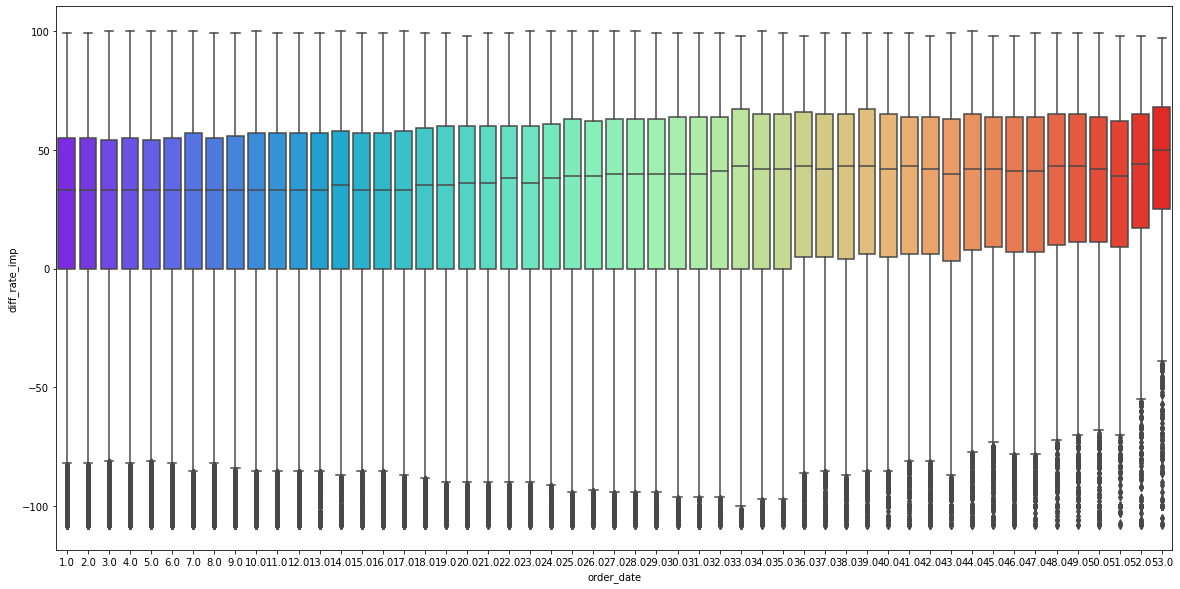

In [123]:
sns.boxplot(x='order_date',y='diff_rate_imp',data=combine_data_3.query('VipType>=0&diff_rate_imp<999&diff_rate_imp>-109'),palette='rainbow')

In [ ]:
sns.boxplot(x='order_date',y='diff_rate_imp',data=combine_data_2.query('VipType>=0&diff_rate_imp<999&diff_rate_imp>-1009'),palette='rainbow')

In [28]:
imp_product_id = (combine_data.query('diff_imp.notnull()').groupby(['product_id','VipType','usage_type'])['total_impression','diff_imp'].sum().reset_index()
                 .merge(combine_data.query('diff_imp.notnull()').groupby('product_id')['date'].count().reset_index(),
                        on='product_id', how='left')
                 .merge(combine_data.query('diff_imp.notnull()').groupby(['product_id','higher_ga_imp'])['date'].count().unstack(level=1).reset_index(),
       on='product_id', how='left').rename(columns = {-1.0:'GA<CA', 0.0: 'GA=CA', 1.0:'GA>CA'})
)

<ipython-input-28-37bf4761a7fd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  imp_product_id = (combine_data.query('diff_imp.notnull()').groupby(['product_id','VipType','usage_type'])['total_impression','diff_imp'].sum().reset_index()


In [29]:
pv_product_id.groupby(['VipType'])

,product_id,VipType,usage_type,total_pageview,diff_pv,date,GA<CA,GA=CA,GA>CA
0,2790817,5,Power User,90.0,34.0,36,23.0,11.0,2.0
1,2952646,5,Power User,221.0,31.0,45,19.0,22.0,4.0
2,2970795,5,Power User,198.0,22.0,36,19.0,12.0,5.0
3,3362630,5,Power User,86.0,17.0,26,12.0,13.0,1.0
4,3394417,5,Power User,89.0,8.0,36,17.0,14.0,5.0


In [111]:
pv_product_id[['total_pageview']].quantile(q=[0.25, 0.5, 0.75, 0.9, 0.99])
# outlier (-6.5, 21.5)
# quantiles = quantiles.to_dict()

,total_pageview
0.25,13.0
0.50,23.0
0.75,42.0
0.90,78.0
0.99,242.0


In [114]:
pv_product_id['segment']=np.where(pv_product_id['total_pageview']<=13,'Q1','Q3')
pv_product_id['segment']=np.where((pv_product_id['total_pageview']>13) & (pv_product_id['total_pageview']<=23) , 'Q2',pv_product_id['segment'])
pv_product_id['segment']=np.where(pv_product_id['total_pageview']>42, 'Q4',pv_product_id['segment'])

In [113]:
imp_product_id['segment']=np.where(imp_product_id['total_impression']<=13, 'Q1','Q3')
imp_product_id['segment']=np.where((imp_product_id['total_impression']>13) & (imp_product_id['total_impression']<=23) , 'Q2',imp_product_id['segment'])
imp_product_id['segment']=np.where(imp_product_id['total_impression']>42, 'Q4',imp_product_id['segment'])

In [128]:
pv_product_id['avg_daily_pv']=pv_product_id['total_pageview']/pv_product_id['date']
pv_product_id['avg_daily_diff_pv']=pv_product_id['diff_pv']/pv_product_id['date']
imp_product_id['avg_daily_imp']=imp_product_id['total_impression']/imp_product_id['date']
imp_product_id['avg_daily_diff_imp']=imp_product_id['diff_imp']/imp_product_id['date']

In [209]:
imp_product_id[['total_pageview']].quantile(q=[0.25, 0.5, 0.75, 0.9, 0.99])
# outlier pv (-6.5, 21.5) outlier
# quantiles = quantiles.to_dict()

KeyError: "None of [Index(['total_pageview'], dtype='object')] are in the [columns]"

In [ ]:
user có nhiều impressiom/power user/nhiều ngày/nhiều impression

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff_pv', ylabel='Density'>

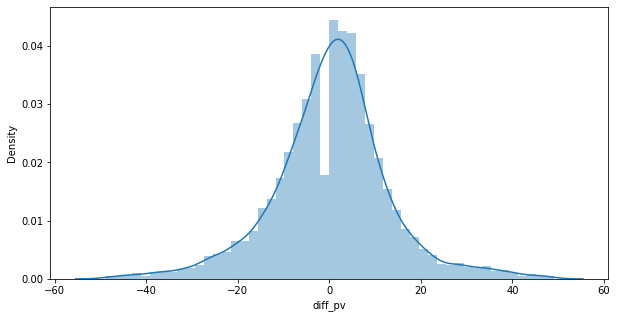

In [91]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
sns.distplot(pv_product_id.query('diff_pv>-50&diff_pv<50&VipType==1')['diff_pv'])

<AxesSubplot:xlabel='VipType', ylabel='avg_daily_pv'>

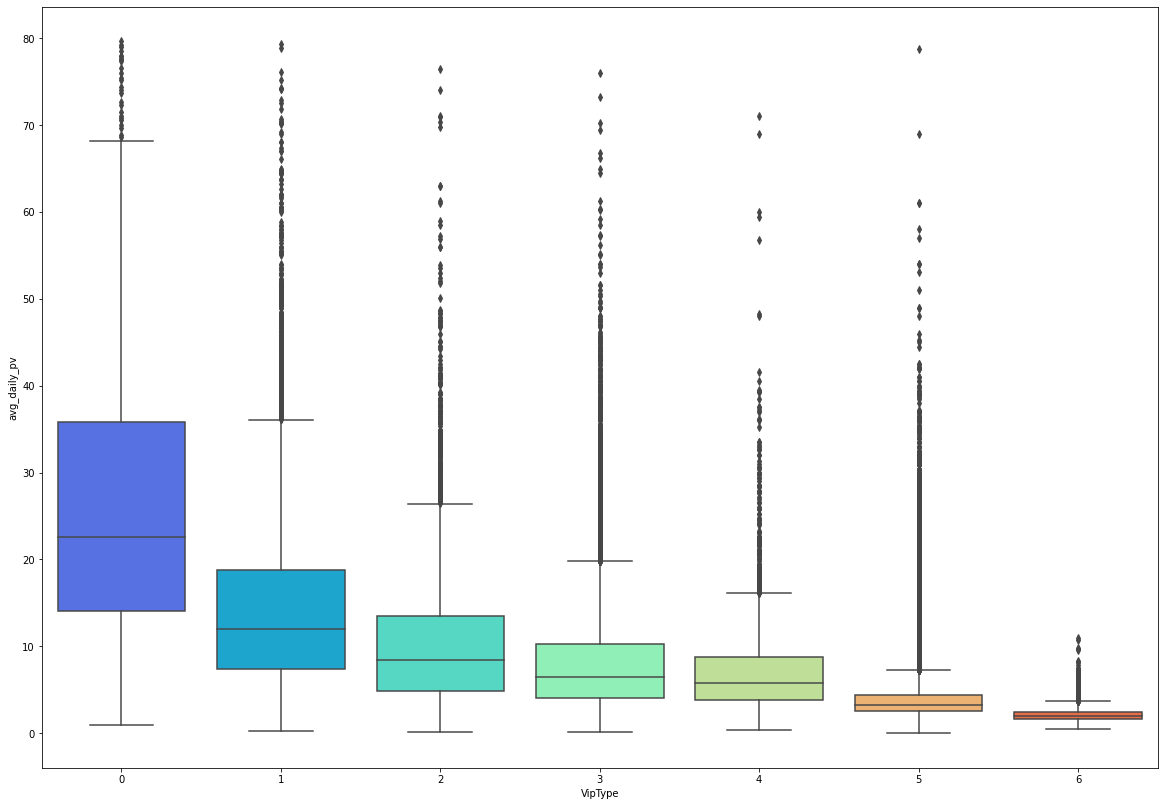

In [131]:
sns.boxplot(x='VipType',y='avg_daily_pv',data=pv_product_id.query('diff_pv>-70&diff_pv<80&avg_daily_pv<80'),palette='rainbow')

<AxesSubplot:xlabel='VipType', ylabel='avg_daily_diff_pv'>

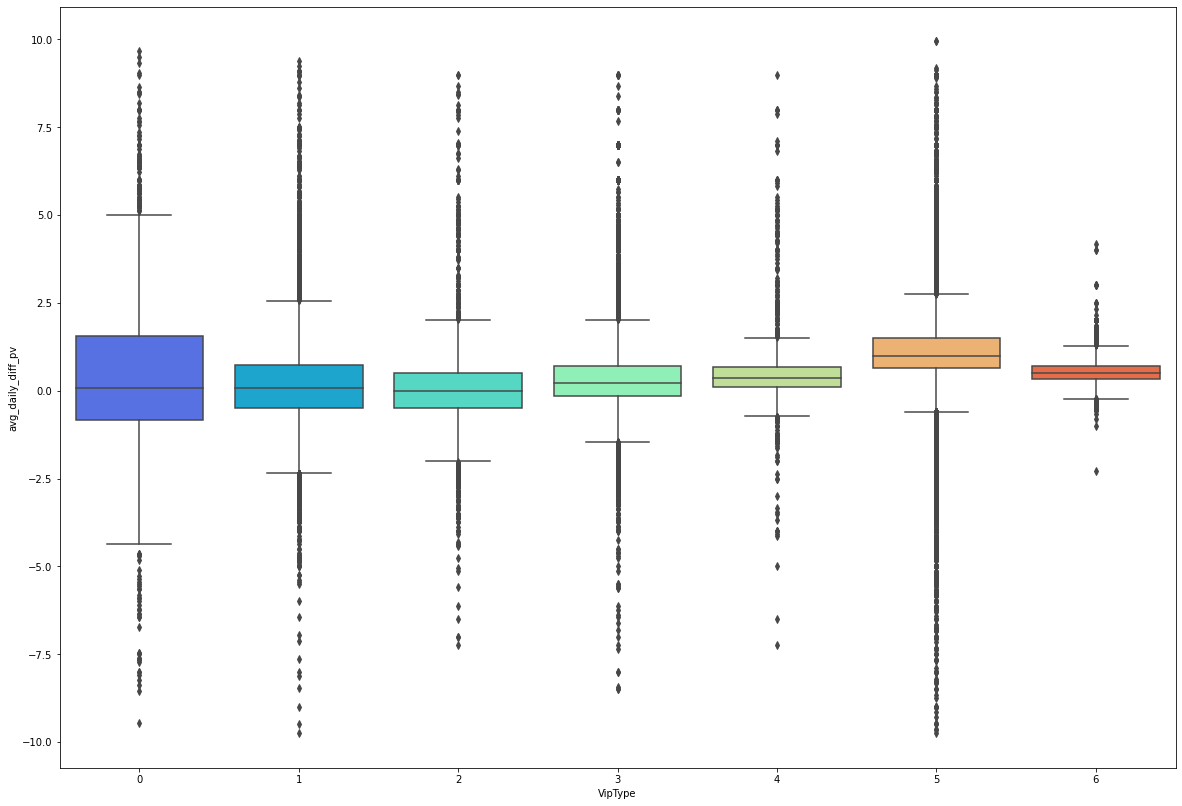

In [138]:
sns.boxplot(x='VipType',y='avg_daily_diff_pv',data=pv_product_id.query('avg_daily_diff_pv<10&avg_daily_diff_pv>-10'),palette='rainbow')

<AxesSubplot:xlabel='VipType', ylabel='avg_daily_diff_imp'>

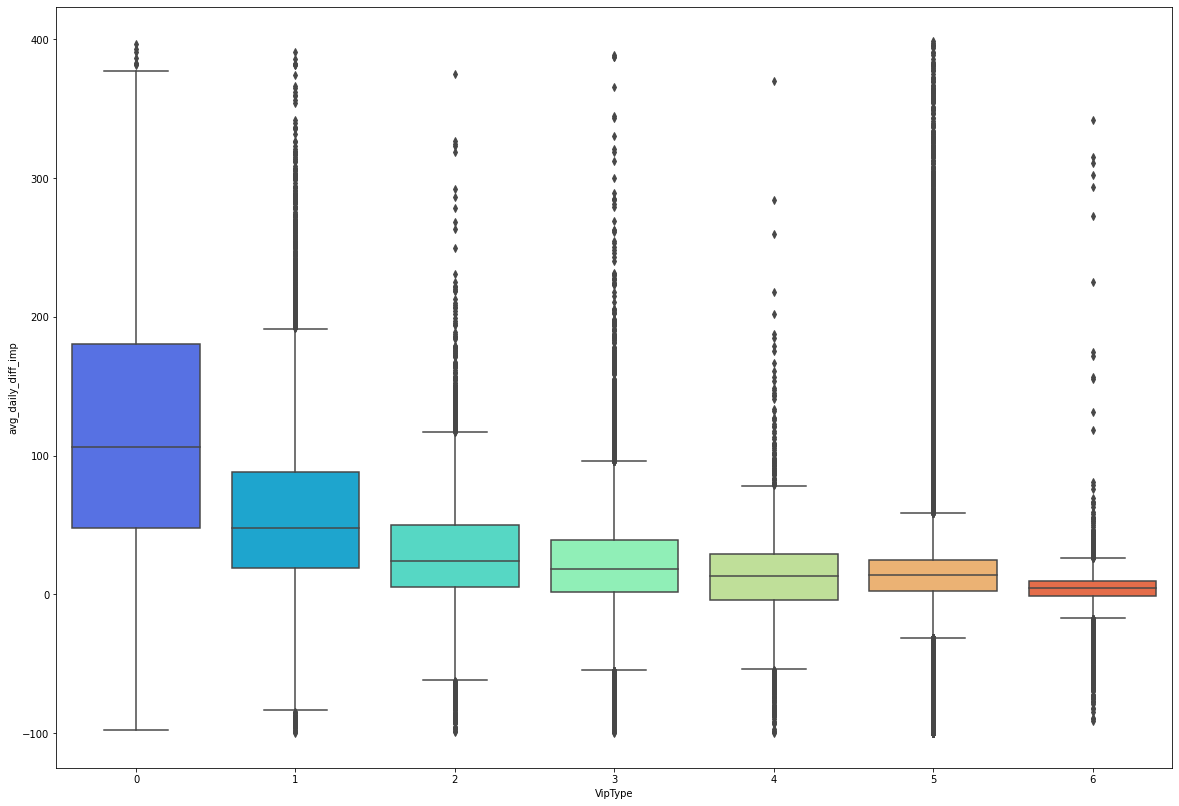

In [142]:
sns.boxplot(x='VipType',y='avg_daily_diff_imp',data=imp_product_id.query('avg_daily_diff_imp<400&avg_daily_diff_imp>-100'),palette='rainbow')

<AxesSubplot:xlabel='VipType', ylabel='avg_daily_imp'>

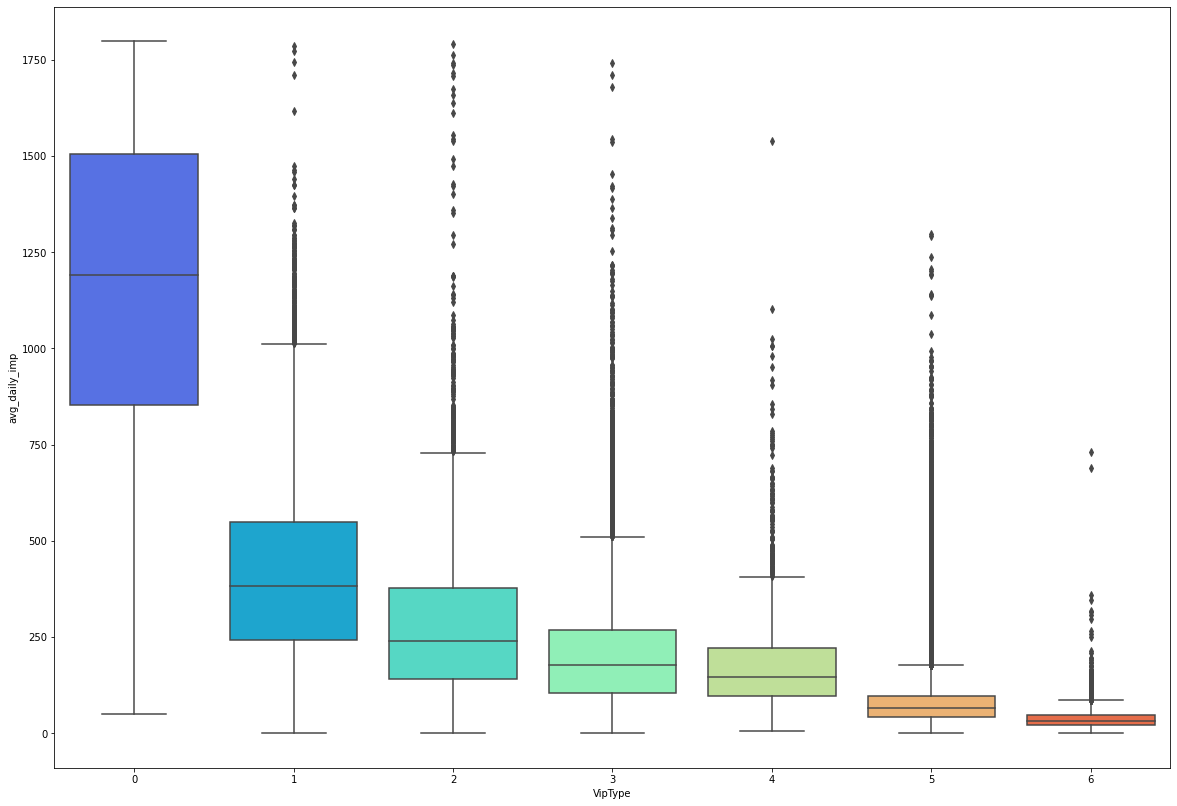

In [134]:
sns.boxplot(x='VipType',y='avg_daily_imp',data=imp_product_id.query('avg_daily_imp<1800'),palette='rainbow')

<AxesSubplot:xlabel='VipType', ylabel='diff_pv'>

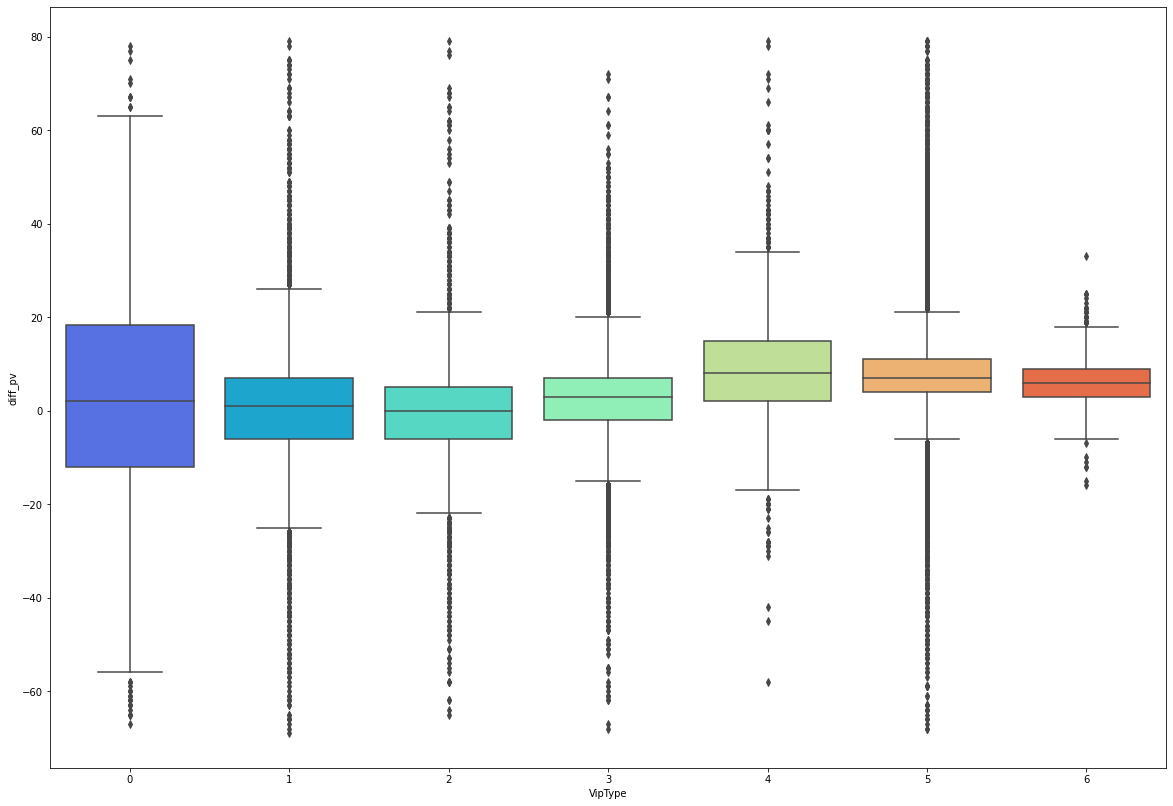

In [109]:
sns.boxplot(x='VipType',y='diff_pv',data=pv_product_id.query('diff_pv>-70&diff_pv<80'),palette='rainbow')

<AxesSubplot:xlabel='VipType', ylabel='total_pageview'>

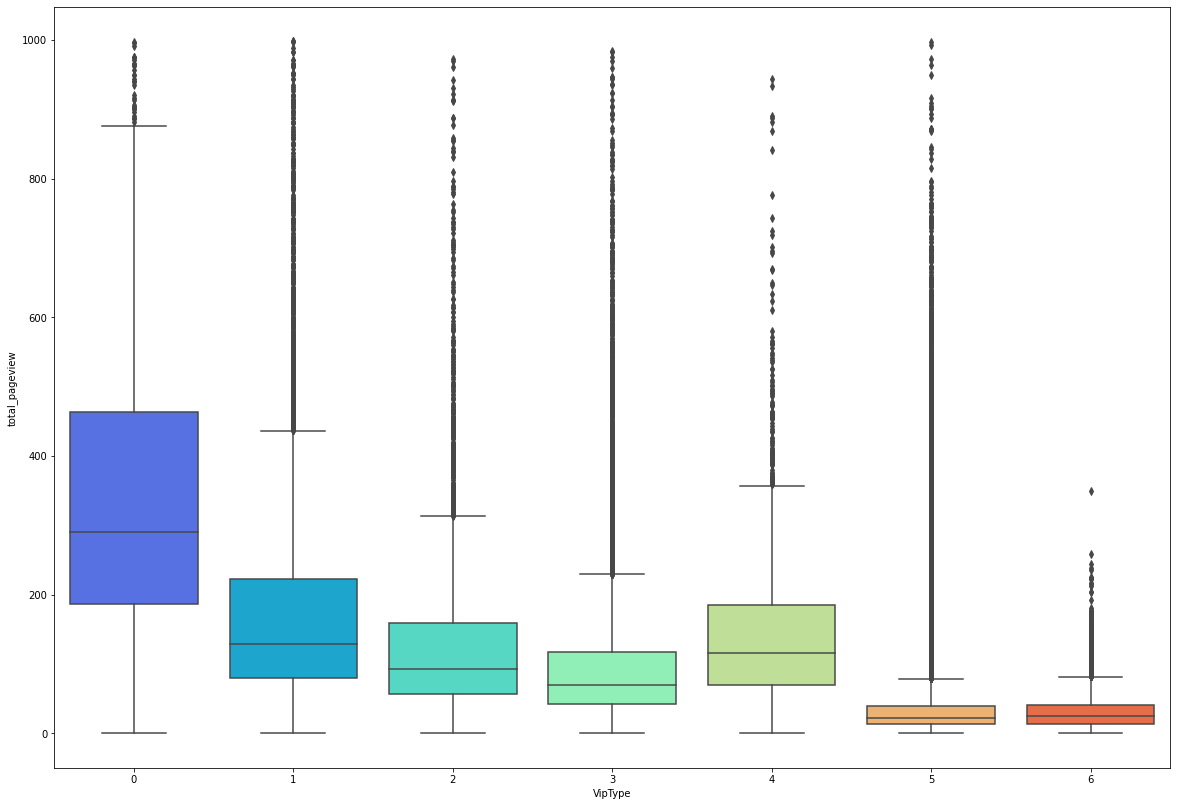

In [118]:
sns.boxplot(x='VipType',y='total_pageview',data=pv_product_id.query('total_pageview<1000'),palette='rainbow')

<AxesSubplot:xlabel='VipType', ylabel='total_impression'>

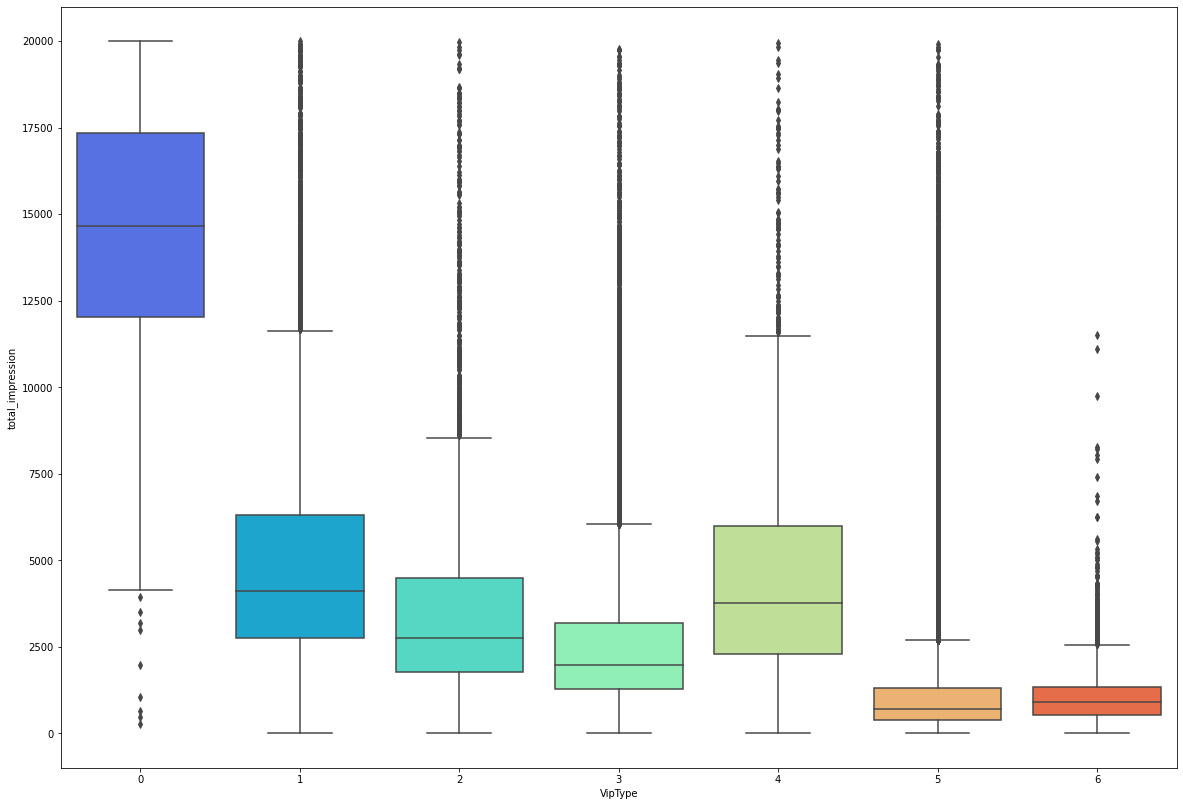

In [120]:
sns.boxplot(x='VipType',y='total_impression',data=imp_product_id.query('total_impression<20000'),palette='rainbow')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/dis

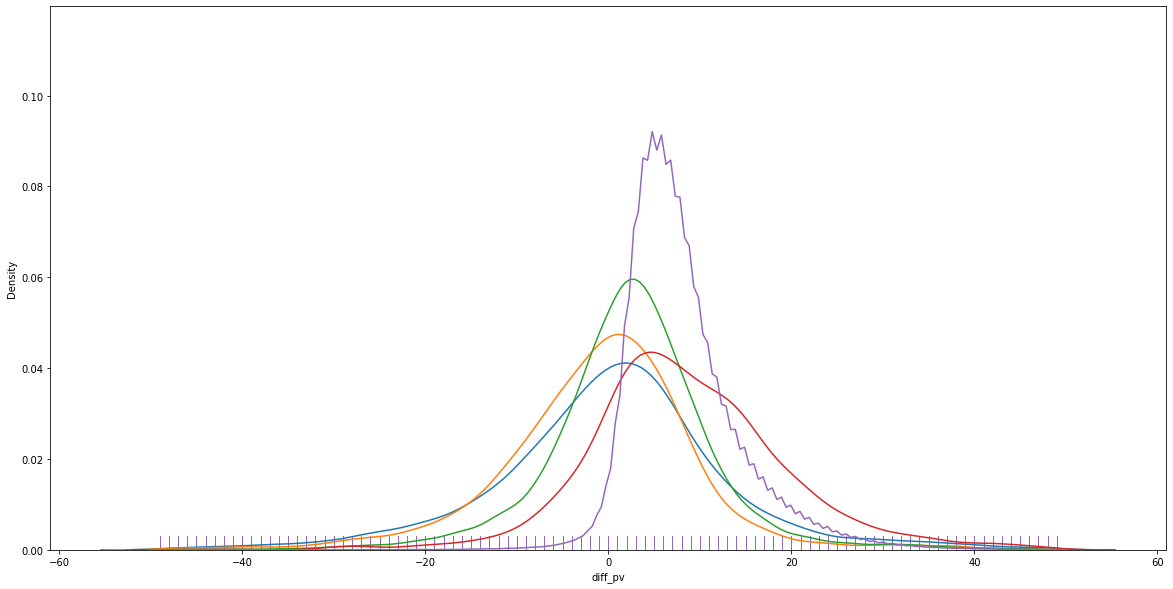

In [85]:
sns.distplot(pv_product_id.query('diff_pv>-50&diff_pv<50&VipType==1')['diff_imp'], hist=False, rug=True)
sns.distplot(pv_product_id.query('diff_pv>-50&diff_pv<50&VipType==2')['diff_imp'], hist=False, rug=True)
sns.distplot(pv_product_id.query('diff_pv>-50&diff_pv<50&VipType==3')['diff_imp'], hist=False, rug=True)
sns.distplot(pv_product_id.query('diff_pv>-50&diff_pv<50&VipType==4')['diff_imp'], hist=False, rug=True)
sns.distplot(pv_product_id.query('diff_pv>-50&diff_pv<50&VipType==5')['diff_imp'], hist=False, rug=True)

plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/dis

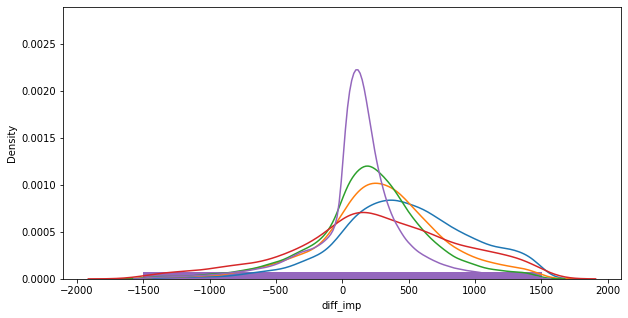

In [99]:

sns.distplot(imp_product_id.query('diff_imp>-1500&diff_imp<1500&VipType==1')['diff_imp'], hist=False, rug=True)
sns.distplot(imp_product_id.query('diff_imp>-1500&diff_imp<1500&VipType==2')['diff_imp'], hist=False, rug=True)
sns.distplot(imp_product_id.query('diff_imp>-1500&diff_imp<1500&VipType==3')['diff_imp'], hist=False, rug=True)
sns.distplot(imp_product_id.query('diff_imp>-1500&diff_imp<1500&VipType==4')['diff_imp'], hist=False, rug=True)
sns.distplot(imp_product_id.query('diff_imp>-1500&diff_imp<1500&VipType==5')['diff_imp'], hist=False, rug=True)
plt.rcParams['figure.figsize'] = (20.0, 14.0)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff_pv', ylabel='Density'>

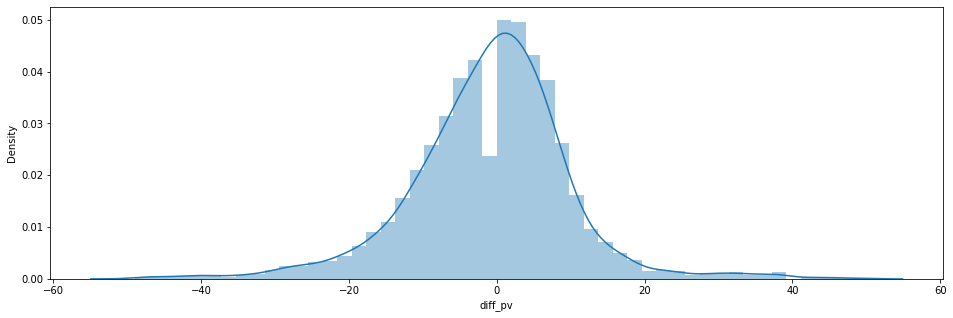

In [72]:
plt.rcParams['figure.figsize'] = (16.0, 5.0)
sns.distplot(pv_product_id.query('diff_pv>-50&diff_pv<50&VipType==2')['diff_pv'])

<AxesSubplot:xlabel='VipType', ylabel='diff_imp'>

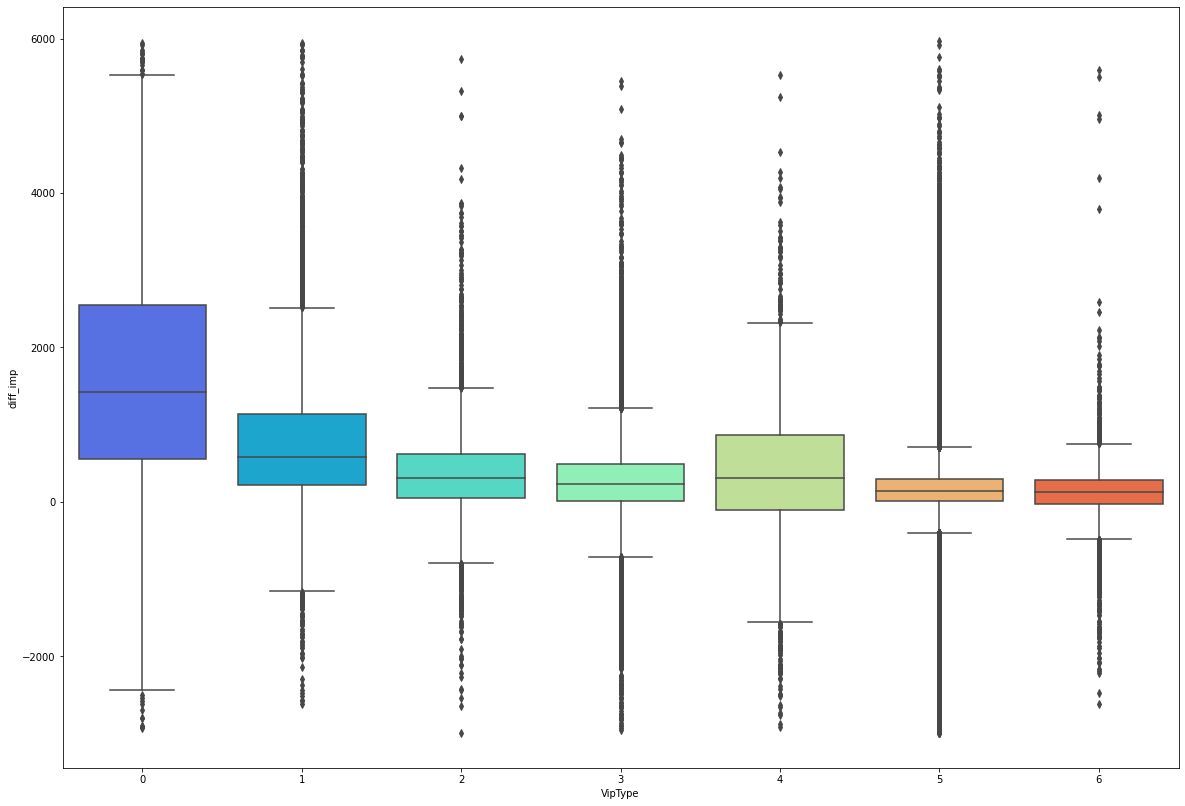

In [104]:
sns.boxplot(x='VipType',y='diff_imp',data=imp_product_id.query('diff_imp>-3000&diff_imp<6000'),palette='rainbow')

In [ ]:
- bao nhiêu user bị lệch Imression mỗi ngày (theo Viptype/usuage_type)
- bao nhiêu user bị lệch impression total (theo Viptype/usuage_type)
- nếu bị lệch thì nó lệch như nào. 

In [ ]:
- theo total trước

In [144]:
pv_product_id['diff_type']=np.where(pv_product_id['diff_pv']>0,'negative','positive')
imp_product_id['diff_type']=np.where(imp_product_id['diff_imp']>0,'negative','positive')

In [ ]:
coi theo user --> 1 user có bao nhiêu ngày lệch.

In [146]:
imp_product_id.groupby(['diff_type','usage_type','VipType'])['product_id'].count().unstack(level=0).reset_index()

diff_type,usage_type,VipType,negative,positive
0,Business,0,422.0,73.0
1,Business,1,2350.0,303.0
2,Business,2,1103.0,281.0
3,Business,3,5672.0,1694.0
4,Business,4,211.0,87.0
5,Business,5,271821.0,78521.0
6,Casual User,0,108.0,25.0
7,Casual User,1,587.0,119.0
8,Casual User,2,450.0,156.0
9,Casual User,3,1105.0,398.0


In [147]:
pv_product_id.groupby(['diff_type','usage_type','VipType'])['product_id'].count().unstack(level=0).reset_index()

diff_type,usage_type,VipType,negative,positive
0,Business,0,286.0,209.0
1,Business,1,1342.0,1310.0
2,Business,2,629.0,755.0
3,Business,3,4424.0,2940.0
4,Business,4,257.0,41.0
5,Business,5,336954.0,13531.0
6,Casual User,0,72.0,61.0
7,Casual User,1,376.0,330.0
8,Casual User,2,293.0,313.0
9,Casual User,3,919.0,583.0


In [156]:
pv_product_id.columns

Index(['product_id', 'VipType', 'usage_type', 'total_pageview', 'diff_pv',
       'date', 'GA<CA', 'GA=CA', 'GA>CA', 'segment', 'avg_daily_pv',
       'avg_daily_diff_pv', 'diff_type'],
      dtype='object')

In [161]:
pv_product_id.query('diff_type=="positive"').groupby(['usage_type','VipType'])[]

,product_id,VipType,usage_type,total_pageview,diff_pv,date,GA<CA,GA=CA,GA>CA,segment,avg_daily_pv,avg_daily_diff_pv,diff_type
50,4684227,1,Casual User,329.0,-10.0,36,21.0,3.0,12.0,Q4,9.138889,-0.277778,positive
59,4957818,2,Power User,159.0,-4.0,67,32.0,8.0,27.0,Q4,2.373134,-0.059701,positive
60,4957818,3,Power User,102.0,0.0,67,32.0,8.0,27.0,Q4,1.522388,0.000000,positive
69,4987888,5,Power User,6.0,0.0,4,2.0,NaN,2.0,Q1,1.500000,0.000000,positive
79,5007916,3,Frequent User,263.0,-7.0,11,3.0,2.0,6.0,Q4,23.909091,-0.636364,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
982077,31642562,5,Business,3.0,-1.0,1,NaN,NaN,1.0,Q1,3.000000,-1.000000,positive
982994,31643583,5,Power User,6.0,0.0,1,NaN,1.0,NaN,Q1,6.000000,0.000000,positive
983223,31643839,5,Power User,3.0,-1.0,1,NaN,NaN,1.0,Q1,3.000000,-1.000000,positive
984507,31645404,5,Business,8.0,-2.0,1,NaN,NaN,1.0,Q1,8.000000,-2.000000,positive


In [ ]:
mean/max - trung vị, max  của 1 pageviews. min cách 

In [ ]:
combine_data.head()

In [169]:
pv_product_id.groupby(['VipType','segment'])['product_id'].count().unstack(level=0)

VipType,0,1,2,3,4,5,6
segment,,,,,,,
Q1,2,79,68,514,27,247074,1536
Q2,2,99,100,1285,52,254661,1427
Q3,7,386,553,4502,136,225679,1760
Q4,1571,7618,4263,18683,1873,209663,1455


In [203]:
imp_product_id['diff_rate'] = imp_product_id['diff_imp']/imp_product_id['total_impression']

In [208]:
# imp_product_id['rate']=np.where(imp_product_id['diff_rate']<0.1,"0-10%","50+%")
imp_product_id['rate']=np.where((imp_product_id['diff_rate']<0.2)&(imp_product_id['diff_rate']>=0.1),"10-20%",imp_product_id['rate'])
imp_product_id['rate']=np.where((imp_product_id['diff_rate']<0.5)&(imp_product_id['diff_rate']>=0.2),"20-50%",imp_product_id['rate'])

In [ ]:
imp_product_id.head()

In [ ]:
tuần qua tuần thay đổi như nào- lấy 1 tuần cũng được - ý là sao nhỉ. 

In [202]:
pv_product_id.query('diff_pv>0&diff_rate>=0.2').groupby('segment')['product_id'].count()

segment
Q1    219616
Q2    215690
Q3    165795
Q4     95329
Name: product_id, dtype: int64

In [199]:
pv_product_id.head()

,product_id,VipType,usage_type,total_pageview,diff_pv,date,GA<CA,GA=CA,GA>CA,segment,avg_daily_pv,avg_daily_diff_pv,diff_type,diff_rate
0,2790817,5,Power User,90.0,34.0,36,23.0,11.0,2.0,Q4,2.500000,0.944444,negative,0.377778
1,2952646,5,Power User,221.0,31.0,45,19.0,22.0,4.0,Q4,4.911111,0.688889,negative,0.140271
2,2970795,5,Power User,198.0,22.0,36,19.0,12.0,5.0,Q4,5.500000,0.611111,negative,0.111111
3,3362630,5,Power User,86.0,17.0,26,12.0,13.0,1.0,Q4,3.307692,0.653846,negative,0.197674
4,3394417,5,Power User,89.0,8.0,36,17.0,14.0,5.0,Q4,2.472222,0.222222,negative,0.089888


In [187]:
(pv_product_id.query('segment=="Q1"&diff_pv>0')
 .groupby(['diff_pv'])['product_id'].count().sort_values(ascending=False)
 .reset_index().head(30)
#  .sum()
)

,diff_pv,product_id
0,4.0,42326
1,3.0,39417
2,5.0,37171
3,2.0,29216
4,6.0,29107
5,7.0,20801
6,1.0,15928
7,8.0,12681
8,9.0,6404
9,10.0,2615


In [178]:
(pv_product_id.query('segment=="Q2"&diff_pv>0')
 .groupby(['diff_pv'])['product_id'].count().sort_values(ascending=False)
#  .reset_index().head(30)
 .sum()
)

248998

In [179]:
(pv_product_id.query('segment=="Q3"&diff_pv>0')
 .groupby(['diff_pv'])['product_id'].count().sort_values(ascending=False)
#  .reset_index().head(30)
 .sum()
)

223052

In [180]:
(pv_product_id.query('segment=="Q4"&diff_pv>0')
 .groupby(['diff_pv'])['product_id'].count().sort_values(ascending=False)
#  .reset_index().head(30)
 .sum()
)

221666

In [ ]:
chia theo quantile thì nhóm nào lệch nhiều hơn --> nhóm Q4 lệch nhiều rồi

In [ ]:
theo quantile thì loại user nào ở nhóm nào nhiều hơn. 

In [220]:
pv_product_id.head()

,product_id,VipType,usage_type,total_pageview,diff_pv,date,GA<CA,GA=CA,GA>CA,segment,avg_daily_pv,avg_daily_diff_pv,diff_type,diff_rate,max,mean,median,min
0,2790817,5,Power User,90.0,34.0,36,23.0,11.0,2.0,Q4,2.500000,0.944444,negative,0.377778,5.0,2.571429,2.0,1.0
1,2952646,5,Power User,221.0,31.0,45,19.0,22.0,4.0,Q4,4.911111,0.688889,negative,0.140271,14.0,4.911111,4.0,1.0
2,2970795,5,Power User,198.0,22.0,36,19.0,12.0,5.0,Q4,5.500000,0.611111,negative,0.111111,15.0,5.500000,5.0,1.0
3,3362630,5,Power User,86.0,17.0,26,12.0,13.0,1.0,Q4,3.307692,0.653846,negative,0.197674,8.0,3.307692,3.0,1.0
4,3394417,5,Power User,89.0,8.0,36,17.0,14.0,5.0,Q4,2.472222,0.222222,negative,0.089888,10.0,2.542857,2.0,1.0


In [224]:
pv_product_id.query('(max-min>50)&diff_rate>0.2')

,product_id,VipType,usage_type,total_pageview,diff_pv,date,GA<CA,GA=CA,GA>CA,segment,avg_daily_pv,avg_daily_diff_pv,diff_type,diff_rate,max,mean,median,min
4396,16453412,5,Power User,38.0,11.0,20,11.0,3.0,6.0,Q3,1.900000,0.550000,negative,0.289474,68.0,16.300000,5.5,1.0
12238,21665113,5,Power User,19.0,8.0,30,12.0,9.0,9.0,Q2,0.633333,0.266667,negative,0.421053,55.0,26.033333,33.5,1.0
16997,23376593,5,Business,27.0,9.0,17,15.0,1.0,1.0,Q3,1.588235,0.529412,negative,0.333333,61.0,17.687500,14.5,2.0
19091,23952593,5,Power User,90.0,19.0,41,13.0,12.0,16.0,Q4,2.195122,0.463415,negative,0.211111,77.0,16.439024,14.0,1.0
19210,23974234,5,Power User,72.0,16.0,19,9.0,7.0,3.0,Q4,3.789474,0.842105,negative,0.222222,63.0,18.315789,19.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920186,31577802,0,Frequent User,221.0,48.0,6,6.0,NaN,NaN,Q4,36.833333,8.000000,negative,0.217195,79.0,36.833333,30.0,15.0
942494,31600864,5,Power User,76.0,65.0,4,3.0,1.0,NaN,Q4,19.000000,16.250000,negative,0.855263,66.0,19.000000,4.5,1.0
971232,31630752,5,Power User,197.0,189.0,2,1.0,1.0,NaN,Q4,98.500000,94.500000,negative,0.959391,192.0,98.500000,98.5,5.0
971633,31631194,5,Power User,1737.0,1727.0,2,2.0,NaN,NaN,Q4,868.500000,863.500000,negative,0.994243,1286.0,868.500000,868.5,451.0


In [227]:
pv_product_id.groupby('date')['product_id'].count().head(30).reset_index()

,date,product_id
0,1,23616
1,2,48390
2,3,80634
3,4,110625
4,5,113269
5,6,98298
6,7,83942
7,8,77421
8,9,35334
9,10,33022


In [21]:
# combine_data['date']=pd.to_datetime(combine_data['date'])
# combine_data['date_begin']=pd.to_datetime(combine_data['date_begin'])
combine_data["order_date"] = combine_data.groupby("product_id")["date"].rank("dense", ascending=True)
# combine_data["order_date_from_begin"] = (combine_data['date']-combine_data['date_begin']).dt.days+1
combine_data_2["order_date"] = combine_data_2.groupby("product_id")["date"].rank("dense", ascending=True)
combine_data_3["order_date"] = combine_data_3.groupby("product_id")["date"].rank("dense", ascending=True)

In [22]:
combine_data.head()

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
0,2021-11-30,24492465,230.0,4.0,1.0,187.0,1681037,5,None,Business,-1.0,43.0,19.0,-1.0,3.0,75.0,50.0
1,2021-10-03,30449161,232.0,4.0,1.0,161.0,663895,5,None,Power User,-1.0,71.0,31.0,-1.0,3.0,75.0,2.0
2,2021-11-14,31210754,89.0,7.0,10.0,71.0,1717285,5,None,Frequent User,-1.0,18.0,20.0,1.0,-3.0,-43.0,17.0
3,2021-11-11,31396127,76.0,8.0,2.0,10.0,1437192,5,None,Power User,-1.0,66.0,87.0,-1.0,6.0,75.0,1.0
4,2021-10-15,28591105,185.0,9.0,5.0,95.0,387051,5,None,Business,-1.0,90.0,49.0,-1.0,4.0,44.0,15.0


In [242]:
gc.collect()

0

In [241]:
combine_data["order_date"] = combine_data.groupby("product_id")["date"].rank("dense", ascending=True)

In [23]:
combine_data.head()

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
0,2021-11-30,24492465,230.0,4.0,1.0,187.0,1681037,5,None,Business,-1.0,43.0,19.0,-1.0,3.0,75.0,50.0
1,2021-10-03,30449161,232.0,4.0,1.0,161.0,663895,5,None,Power User,-1.0,71.0,31.0,-1.0,3.0,75.0,2.0
2,2021-11-14,31210754,89.0,7.0,10.0,71.0,1717285,5,None,Frequent User,-1.0,18.0,20.0,1.0,-3.0,-43.0,17.0
3,2021-11-11,31396127,76.0,8.0,2.0,10.0,1437192,5,None,Power User,-1.0,66.0,87.0,-1.0,6.0,75.0,1.0
4,2021-10-15,28591105,185.0,9.0,5.0,95.0,387051,5,None,Business,-1.0,90.0,49.0,-1.0,4.0,44.0,15.0


In [24]:
combine_data.groupby('order_date')['product_id'].count()

order_date
1.0     872623
2.0     872140
3.0     871605
4.0     870842
5.0     869683
         ...  
57.0     90137
58.0     81799
59.0     73032
60.0     63833
61.0     50581
Name: product_id, Length: 61, dtype: int64

In [ ]:
biểu diễn, ví dụ trong vòng 7 ngày đầu

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

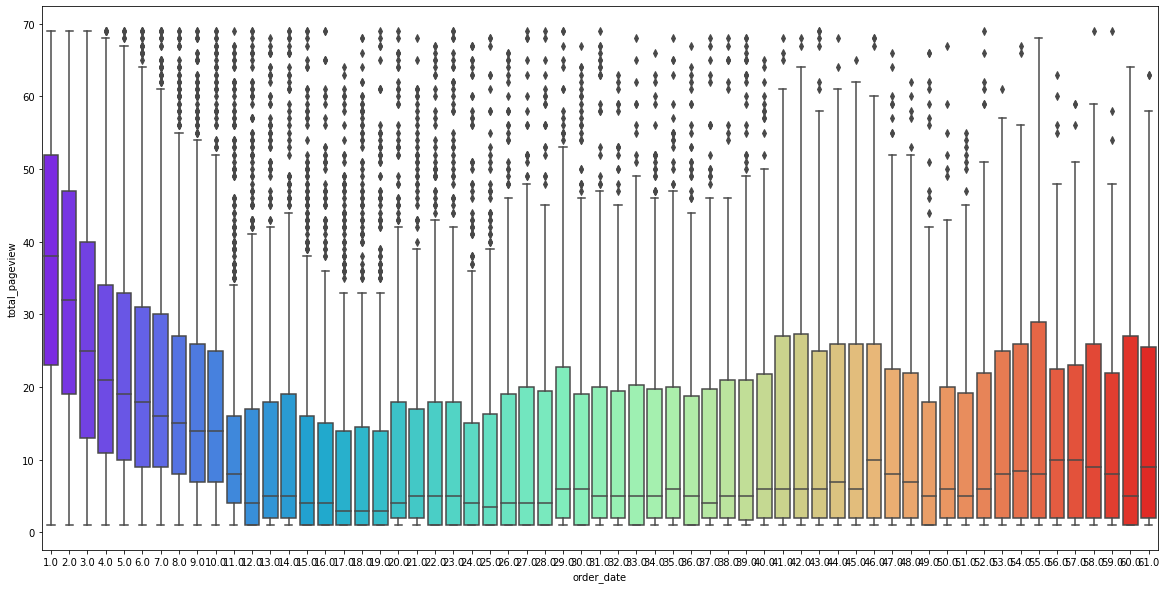

In [32]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data.query('VipType==0&total_pageview<70'),palette='rainbow')

<AxesSubplot:xlabel='order_date', ylabel='total_pageview'>

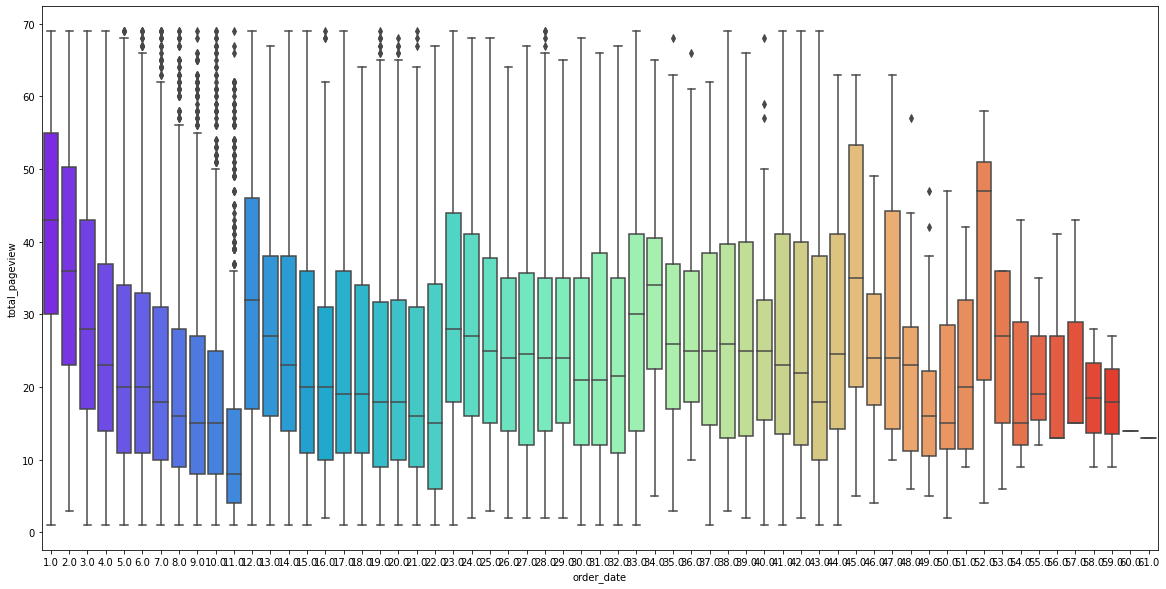

In [52]:
sns.boxplot(x='order_date',y='total_pageview',data=combine_data_2.query('VipType==0&total_pageview<70'),palette='rainbow')

In [54]:
combine_data_2.groupby('product_id')['date'].nunique().reset_index().groupby('date')['product_id'].count()

date
1     15505
2     16119
3      7196
4     12584
5     20125
      ...  
57      836
58      755
59      468
60      306
61      204
Name: product_id, Length: 61, dtype: int64

In [55]:
combine_data_3.groupby('product_id')['date'].nunique().reset_index().groupby('date')['product_id'].count()

date
1     65083
2     53893
3     48436
4     43345
5     38596
6     34274
7     30831
8     28160
9     24945
10    23997
11    22580
12    20917
13    19355
14    18214
15    17135
16    14665
17    14714
18    14084
19    13091
20    12104
21    12041
22    11343
23     9961
24     9734
25     9874
26     9130
27     8594
28     8497
29     9222
30     7477
31     7070
32     6776
33     6212
34     6034
35     5958
36     5776
37     7102
38     5506
39     5524
40     4490
41     4597
42     4436
43     4480
44     3951
45     6821
46     3338
47     2706
48     2673
49     2799
50     4320
51     2626
52     2681
53     6959
Name: product_id, dtype: int64

In [56]:
combine_data.groupby('product_id')['date'].nunique().reset_index().groupby('date')['product_id'].count()

date
1       483
2       535
3       763
4      1158
5      2450
      ...  
57     8154
58     8573
59     9026
60    13024
61    49621
Name: product_id, Length: 61, dtype: int64

<AxesSubplot:xlabel='order_date', ylabel='diff_pv'>

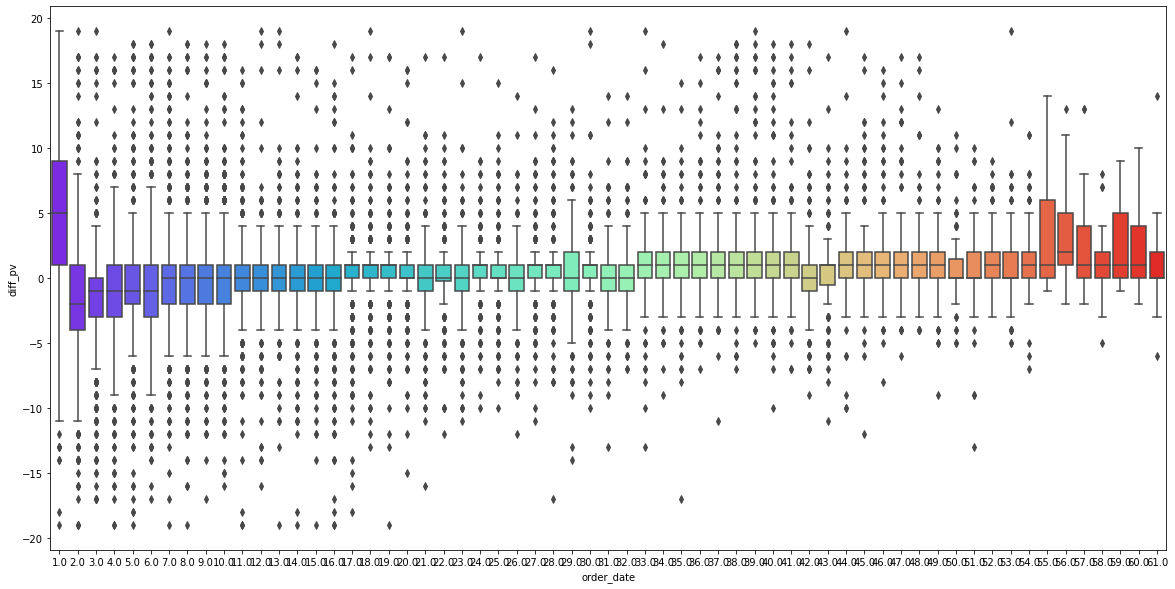

In [31]:
sns.boxplot(x='order_date',y='diff_pv',data=combine_data.query('VipType==0&total_pageview<100&diff_pv<20&diff_pv>-20'),palette='rainbow')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/dis

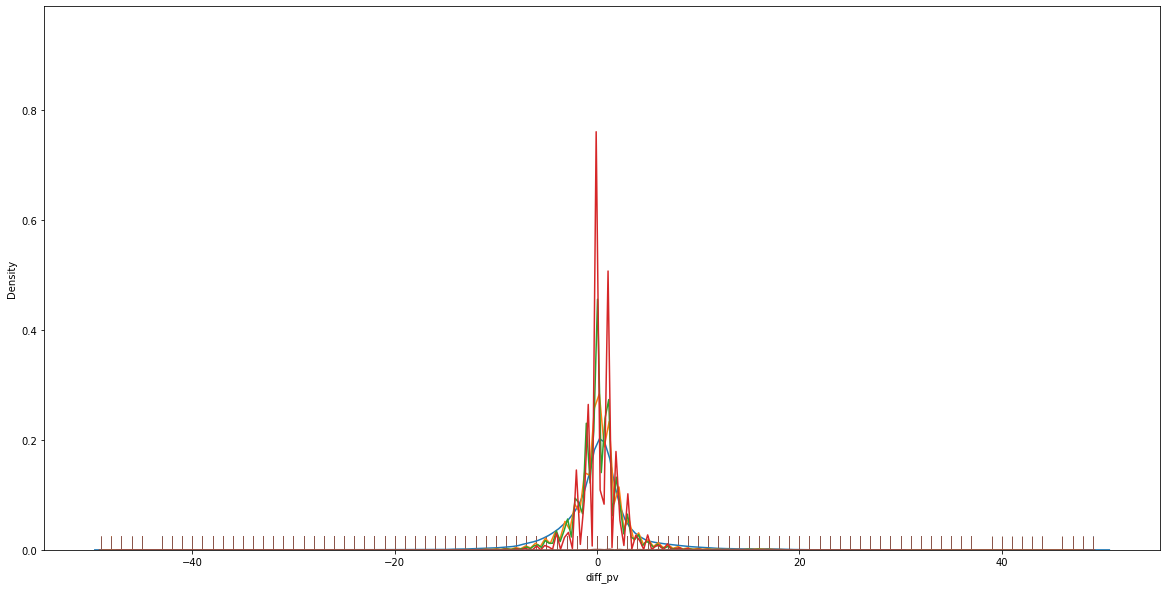

In [39]:
sns.distplot(combine_data.query('diff_pv>-50&diff_pv<50&VipType==0')['diff_pv'], hist=False, rug=True)
sns.distplot(combine_data.query('diff_pv>-50&diff_pv<50&VipType==1')['diff_pv'], hist=False, rug=True)
sns.distplot(combine_data.query('diff_pv>-50&diff_pv<50&VipType==2')['diff_pv'], hist=False, rug=True)
sns.distplot(combine_data.query('diff_pv>-50&diff_pv<50&VipType==3')['diff_pv'], hist=False, rug=True)
sns.distplot(combine_data.query('diff_pv>-50&diff_pv<50&VipType==4')['diff_pv'], hist=False, rug=True)
sns.distplot(combine_data.query('diff_pv>-50&diff_pv<50&VipType==5')['diff_pv'], hist=False, rug=True)

plt.show()

In [40]:
1 product_id, các giai đoạn, thì nó lệch như nào (trong duration, ngoài duration)
- daily, lấy trung bình, trong duration, đang lệch bao nhiêu cái, 1 cái , 2 cái. - có thể chia ra từ ngày 1-7, tin renew, ngoài duration
- daily, ngoài duration 

SyntaxError: invalid syntax (<ipython-input-40-faa782a2b010>, line 1)

In [ ]:
plt.rcParams['figure.figsize'] = (16.0, 5.0)
sns.distplot(combine_data.query('diff_pv>-50&diff_pv<50&VipType==2')['diff_pv'])

## For analysis

In [35]:
combine_data.query('product_id==24492465')

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,VipType,user_id,usage_type,higher_ga_imp,diff_imp,diff_rate_imp,higher_ga_pv,diff_pv,diff_rate_pv,order_date
0,2021-11-30,24492465,230.0,4.0,1.0,187.0,1681037,5,None,Business,-1.0,43.0,19.0,-1.0,3.0,75.0,50.0
90113,2021-11-30,24492465,230.0,4.0,1.0,187.0,500344,5,None,Power User,-1.0,43.0,19.0,-1.0,3.0,75.0,50.0
122720,2021-11-24,24492465,3.0,3.0,7.0,7.0,500344,5,None,Power User,1.0,-4.0,-133.0,1.0,-4.0,-133.0,48.0
125693,2021-11-24,24492465,3.0,3.0,7.0,7.0,1681037,5,None,Business,1.0,-4.0,-133.0,1.0,-4.0,-133.0,48.0
654384,2021-10-14,24492465,276.0,8.0,5.0,252.0,1681037,5,None,Business,-1.0,24.0,9.0,-1.0,3.0,38.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24463166,2021-10-26,24492465,39.0,2.0,1.0,29.0,500344,5,None,Power User,-1.0,10.0,26.0,-1.0,1.0,50.0,24.0
24537568,2021-10-29,24492465,28.0,3.0,2.0,8.0,1681037,5,None,Business,-1.0,20.0,71.0,-1.0,1.0,33.0,27.0
24659630,2021-10-29,24492465,28.0,3.0,2.0,8.0,500344,5,None,Power User,-1.0,20.0,71.0,-1.0,1.0,33.0,27.0
25027803,2021-10-03,24492465,357.0,3.0,1.0,296.0,1681037,5,None,Business,-1.0,61.0,17.0,-1.0,2.0,67.0,1.0


In [37]:
combine_data.count()

date                24874904
product_id          24874904
total_impression    23837285
total_pageview      10991971
ga_pageviews         9639873
ga_impression       22796001
CreateByUser        24874904
VipType             24874904
user_id               751595
usage_type          24874904
higher_ga_imp       24650644
diff_imp            24650644
diff_rate_imp       24650644
higher_ga_pv        11289420
diff_pv             11289420
diff_rate_pv        11286754
order_date          24874904
dtype: int64

In [38]:
combine_data_2.count()

date                24869068
product_id          24869068
total_impression    23831694
total_pageview      10989001
ga_pageviews         9637241
ga_impression       22790533
VipType             24869068
user_id               751595
higher_ga_imp       24644853
diff_imp            24644853
diff_rate_imp       24644853
higher_ga_pv        11286369
diff_pv             11286369
diff_rate_pv        11283703
order_date          24869068
dtype: int64

In [36]:
combine_data_2=combine_data.drop(columns ={'CreateByUser','usage_type'}).drop_duplicates()

In [217]:
imp_product_id=(imp_product_id
 .merge(combine_data.groupby('product_id')['total_impression'].agg({np.mean, np.median, max, min}).reset_index()
        , on = 'product_id', how='left')
)
pv_product_id=(pv_product_id
 .merge(combine_data.groupby('product_id')['total_pageview'].agg({np.mean, np.median, max, min}).reset_index()
        , on = 'product_id', how='left')
)

In [218]:
pv_product_id['']

,product_id,VipType,usage_type,total_pageview,diff_pv,date,GA<CA,GA=CA,GA>CA,segment,avg_daily_pv,avg_daily_diff_pv,diff_type,diff_rate,max,mean,median,min
0,2790817,5,Power User,90.0,34.0,36,23.0,11.0,2.0,Q4,2.500000,0.944444,negative,0.377778,5.0,2.571429,2.0,1.0
1,2952646,5,Power User,221.0,31.0,45,19.0,22.0,4.0,Q4,4.911111,0.688889,negative,0.140271,14.0,4.911111,4.0,1.0
2,2970795,5,Power User,198.0,22.0,36,19.0,12.0,5.0,Q4,5.500000,0.611111,negative,0.111111,15.0,5.500000,5.0,1.0
3,3362630,5,Power User,86.0,17.0,26,12.0,13.0,1.0,Q4,3.307692,0.653846,negative,0.197674,8.0,3.307692,3.0,1.0
4,3394417,5,Power User,89.0,8.0,36,17.0,14.0,5.0,Q4,2.472222,0.222222,negative,0.089888,10.0,2.542857,2.0,1.0


In [ ]:
(combine_data.groupby('product_id')['date'].count().reset_index()

## 1. Compare Pageviews

In [55]:
combine_data.query('ga_pageviews>0|total_pageview>0').product_id.nunique()

4459535

In [60]:
combine_data.query('(ga_pageviews>0|total_pageview>0)&date_end>="2021-10-01"').product_id.nunique()

1046418

In [61]:
combine_data.query('(ga_pageviews>0|total_pageview>0)&date_end<"2021-10-01"').product_id.nunique()

3357220

In [62]:
3357220/4459535

0.7528183992277222

In [57]:
combine_data.groupby('product_id')['date_end'].nunique().reset_index().query('date_end>1')

,product_id,date_end
90851,6215675.0,2
102755,6776680.0,2
103803,6823557.0,2
103805,6823627.0,2
104490,6852487.0,2
...,...,...
4912638,31460912.0,2
4979334,31530466.0,2
4979732,31530876.0,2
4980047,31531195.0,2


In [59]:
combine_data.query('date_end.isnull()')

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,date_begin,date_end,user_id,diff_pv,diff_imp
53414,2021-10-10,2998983.0,31.0,6.0,5.0,0.0,NaN,None,NaT,None,1.0,31.0
68247,2021-10-08,28643950.0,207.0,0.0,0.0,0.0,NaN,None,NaT,None,0.0,207.0
93834,2021-10-06,28641721.0,79.0,0.0,0.0,0.0,NaN,None,NaT,None,0.0,79.0
105938,2021-11-17,28670750.0,29.0,0.0,0.0,0.0,NaN,None,NaT,None,0.0,29.0
318591,2021-10-25,28663489.0,260.0,0.0,0.0,0.0,NaN,None,NaT,None,0.0,260.0
...,...,...,...,...,...,...,...,...,...,...,...,...
55975343,2021-10-05,28641588.0,28.0,0.0,0.0,0.0,NaN,None,NaT,None,0.0,28.0
55981573,2021-10-04,3072401.0,28.0,3.0,3.0,0.0,NaN,None,NaT,None,0.0,28.0
55994266,2021-11-22,25599690.0,28.0,0.0,0.0,0.0,NaN,None,NaT,None,0.0,28.0
55999672,2021-10-21,28639841.0,28.0,0.0,0.0,0.0,NaN,None,NaT,None,0.0,28.0


In [219]:
import gc
gc.collect()

1176

In [ ]:
4409123
1993170

In [76]:
combine_data.query('ga_pageviews>0|total_pageview>0').groupby('date').product_id.count()

date
2021-10-01    307227
2021-10-02    337872
2021-10-03    347477
2021-10-04    384133
2021-10-05    334555
               ...  
2021-11-26    384472
2021-11-27    341883
2021-11-28    320222
2021-11-29    358314
2021-11-30    364116
Name: product_id, Length: 61, dtype: int64

In [74]:
combine_data.groupby([pd.Grouper(key='date_end', freq='M')])['product_id'].nunique()
# combine_data.groupby(combine_data['date_end'].groupby(pd.Grouper(freq='M'))

date_end
2014-12-31      28039
2015-12-31      47906
2016-12-31      79272
2017-12-31    1035077
2018-12-31     433006
2019-12-31     373267
2020-12-31     582936
2021-12-31    2453241
2022-12-31       2371
Name: product_id, dtype: int64

In [75]:
combine_data.groupby([pd.Grouper(key='date_end', freq='M')])['product_id'].nunique()

date_end
2014-04-30     954
2014-05-31    1841
2014-06-30    2613
2014-07-31    3804
2014-08-31    3548
              ... 
2022-01-31    1278
2022-02-28    1057
2022-03-31      13
2022-04-30      17
2022-05-31       6
Name: product_id, Length: 98, dtype: int64

In [26]:
combine_data['diff_pv']=combine_data['total_pageview']-combine_data['ga_pageviews']
combine_data['diff_imp']=combine_data['total_impression']-combine_data['ga_impression']

In [37]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [44]:
combine_data.query('total_pageview>0&ga_pageviews>0').product_id.nunique()

1946655

In [68]:
(combine_data.query('total_pageview>0|ga_pageviews>0')
              .groupby('product_id')['diff_pv'].sum().reset_index()
 .groupby('diff_pv')['product_id'].count().sort_values(ascending=False).reset_index().assign(ratio = lambda x: x['product_id']*100/4459535)
).head(20)

,diff_pv,product_id,ratio
0,1.0,1559890,34.978759
1,2.0,837300,18.775500
2,3.0,304437,6.826653
3,0.0,267307,5.994055
4,4.0,216025,4.844115
5,5.0,168995,3.789521
6,6.0,143957,3.228072
7,7.0,123676,2.773294
8,8.0,108365,2.429962
9,9.0,92243,2.068444


In [79]:
combine_data['listing_date_end']=np.where(combine_data['date_end']<'2021-01-01', 
                                          'Listing end before 2021','Listing from Jan-Sep 2021')
combine_data['listing_date_end'] = np.where(combine_data['date_end']>'2021-10-01', 
                                          'Listing end from Oct 2021',combine_data['listing_date_end'])

KeyboardInterrupt: 

In [70]:
(combine_data.query('(total_pageview>0|ga_pageviews>0)&date_end>="2021-10-01"')
              .groupby('product_id')['diff_pv'].sum().reset_index()
 .groupby('diff_pv')['product_id'].count().sort_values(ascending=False).reset_index().assign(ratio = lambda x: x['product_id']*100/1046418)
).head(20)

,diff_pv,product_id,ratio
0,6.0,82695,7.902674
1,5.0,81948,7.831287
2,7.0,78833,7.533605
3,4.0,78406,7.492799
4,8.0,73649,7.038201
5,3.0,66430,6.348324
6,9.0,65132,6.224281
7,10.0,57210,5.467222
8,2.0,50103,4.788048
9,11.0,48776,4.661235


In [69]:
(combine_data.query('(total_pageview>0|ga_pageviews>0)&date_end<"2021-10-01"')
              .groupby('product_id')['diff_pv'].sum().reset_index()
 .groupby('diff_pv')['product_id'].count().sort_values(ascending=False).reset_index().assign(ratio = lambda x: x['product_id']*100/3357220)
).head(20)

,diff_pv,product_id,ratio
0,1.0,1508349,44.928512
1,2.0,777433,23.157047
2,0.0,249583,7.434216
3,3.0,232376,6.921679
4,4.0,133826,3.986215
5,5.0,84374,2.513210
6,6.0,59380,1.768725
7,7.0,43439,1.293898
8,-1.0,34048,1.014172
9,8.0,33460,0.996658


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_pageview', ylabel='Density'>

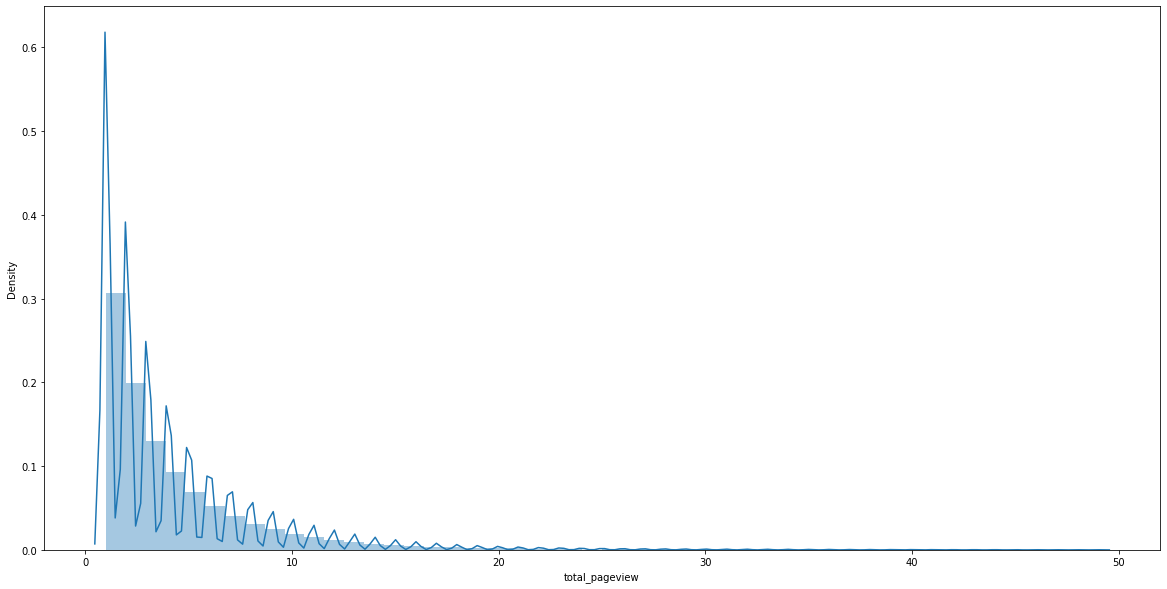

In [21]:
# pageview mỗi ngày
sns.distplot(combine_data.query('(total_pageview>0|ga_pageviews>0)&total_pageview<50')['total_pageview'])
#17-20 page view trên CA đã là 1%, trên GA thì số PG 1 ngày > 12 là outliner. Số này còn phụ thuộc nhiều vào việc tin đăng đó hết hạn từ bao giờ

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_pageview', ylabel='Density'>

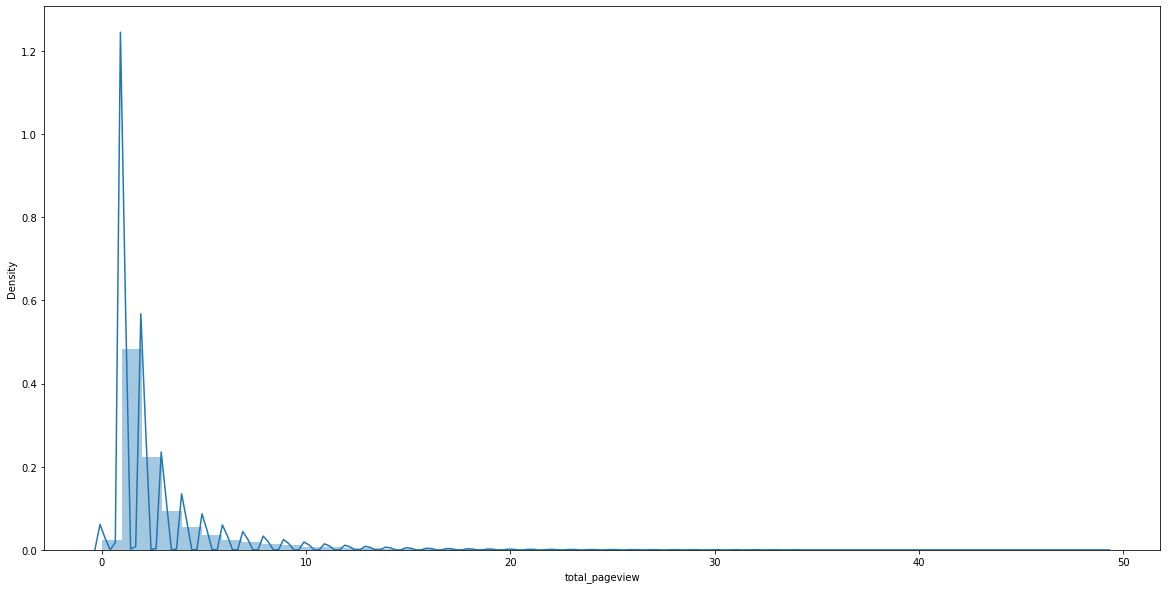

In [83]:
# pageview mỗi ngày
sns.distplot(combine_data.query('(total_pageview>0|ga_pageviews>0)&total_pageview<50&date>="2021-10-01"')['total_pageview'])
#17-20 page view trên CA đã là 1%, trên GA thì số PG 1 ngày > 12 là outliner. Số này còn phụ thuộc nhiều vào việc tin đăng đó hết hạn từ bao giờ

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff_pv', ylabel='Density'>

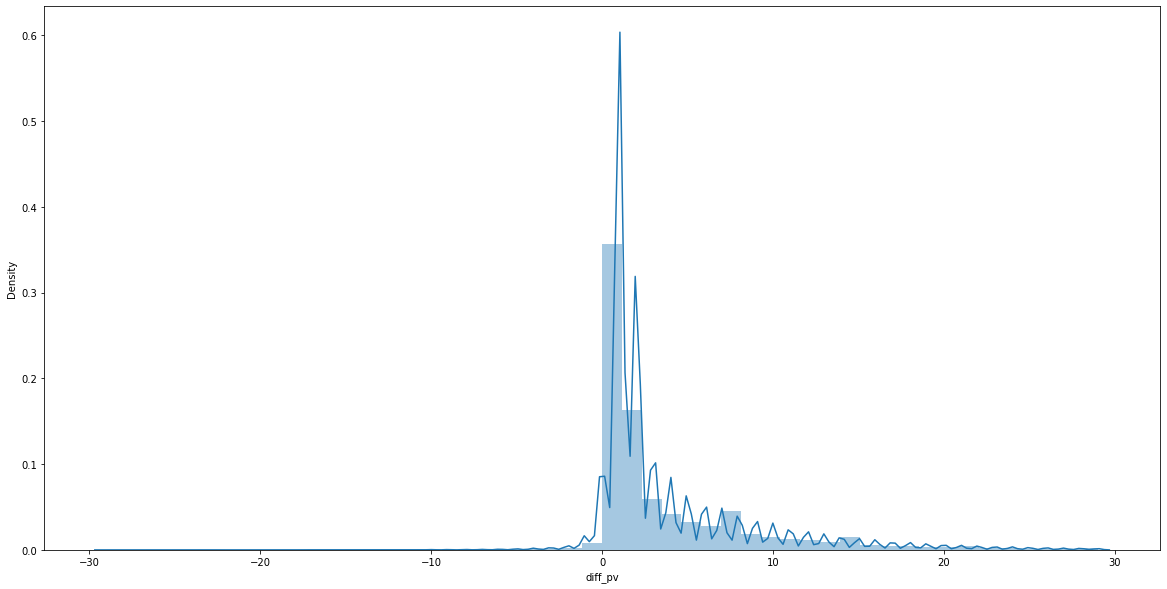

In [63]:
# distribution của total pageviews trong toàn bộ tigan 2 tháng của productid 
(sns.distplot(combine_data.query('total_pageview>0|ga_pageviews>0')
              .groupby('product_id')['diff_pv'].sum().reset_index().query('diff_pv>-30&diff_pv<30')['diff_pv'])
)

In [ ]:
biểu diễn theo date, mỗi ngày bao nhiêu user 

In [ ]:
Bên này count 1, bên này count 0, tin đăng đó hết hạn hay chưa

In [21]:
combine_data.query('ga_pageviews==0&total_pageview>0').groupby('total_pageview')['product_id'].count()

total_pageview
1.0      5673140
2.0      1741774
3.0       344974
4.0       112111
5.0        41530
          ...   
108.0          1
110.0          1
184.0          1
194.0          1
198.0          1
Name: product_id, Length: 65, dtype: int64

In [24]:
combine_data.query('ga_pageviews.isnull()&ga_impression.isnull()').groupby(['total_pageview','total_impression'])['product_id'].count().reset_index().head(30)

,total_pageview,total_impression,product_id
0,0.0,1.0,3030801
1,0.0,2.0,1426856
2,0.0,3.0,778988
3,0.0,4.0,475093
4,0.0,5.0,302766
5,0.0,6.0,203975
6,0.0,7.0,142101
7,0.0,8.0,102373
8,0.0,9.0,74562
9,0.0,10.0,55019


In [11]:
combine_data.query('ga_pageviews.isnull()&ga_impression.isnull()').head()

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,date_begin,date_end,user_id
327,2021-10-21,31075281.0,34.0,1.0,NaN,NaN,663411.0,2021-10-18,2021-10-25,None
2045,2021-10-01,30643842.0,40.0,2.0,NaN,NaN,1678319.0,2021-08-02,2021-08-20,None
4395,2021-11-11,30249125.0,31.0,0.0,NaN,NaN,1173972.0,2021-06-15,2021-11-23,None
6133,2021-11-30,31427046.0,88.0,0.0,NaN,NaN,1689055.0,2021-11-14,2021-11-21,None
6153,2021-10-06,30762010.0,33.0,0.0,NaN,NaN,1507576.0,2021-09-13,2021-09-27,None


In [15]:
combine_data.query('product_id==30643842').sort_values(by='date', ascending=False)

,date,product_id,total_impression,total_pageview,ga_pageviews,ga_impression,CreateByUser,date_begin,date_end,user_id
26945155,2021-11-30,30643842.0,1.0,0.0,NaN,NaN,1678319.0,2021-08-02,2021-08-20,None
26864803,2021-11-29,30643842.0,1.0,0.0,NaN,1.0,1678319.0,2021-08-02,2021-08-20,None
12818935,2021-11-28,30643842.0,NaN,NaN,NaN,1.0,1678319.0,2021-08-02,2021-08-20,None
33298119,2021-11-25,30643842.0,3.0,0.0,NaN,NaN,1678319.0,2021-08-02,2021-08-20,None
28832669,2021-11-24,30643842.0,2.0,0.0,NaN,NaN,1678319.0,2021-08-02,2021-08-20,None
37957060,2021-11-23,30643842.0,4.0,0.0,NaN,1.0,1678319.0,2021-08-02,2021-08-20,None
32072801,2021-11-21,30643842.0,2.0,0.0,NaN,NaN,1678319.0,2021-08-02,2021-08-20,None
21924997,2021-11-20,30643842.0,1.0,0.0,NaN,NaN,1678319.0,2021-08-02,2021-08-20,None
38086671,2021-11-19,30643842.0,4.0,0.0,NaN,NaN,1678319.0,2021-08-02,2021-08-20,None
53411101,2021-11-18,30643842.0,20.0,2.0,1.0,NaN,1678319.0,2021-08-02,2021-08-20,None


In [10]:
(combine_data.query('ga_pageviews.isnull()&ga_impression.isnull()&date_end<"2021-10-01"').groupby('date_end')['product_id'].count()
 .reset_index().sort_values(by='date_end', ascending=False).head(50)
)

,date_end,product_id
2734,2021-09-30,33531
2733,2021-09-29,22291
2732,2021-09-28,20999
2731,2021-09-27,22068
2730,2021-09-26,15617
2729,2021-09-25,17308
2728,2021-09-24,18940
2727,2021-09-23,18672
2726,2021-09-22,11956
2725,2021-09-21,12118


In [19]:
import gc
gc.collect()

19

In [3]:
query="""
SELECT ga_master_table.visit_date, 
    coalesce(ga_master_table_hits.hits_item_id,event_label_productid) as product_id,
    COUNT(CASE WHEN (ga_master_table_hits.hit_type = 'PAGE') THEN concat(ga_master_table.unique_intraaday_id, ga_master_table_hits.hit_time , ga_master_table_hits.hit_number  )  ELSE NULL END) AS total_pageviews
FROM `batdongsan-datalake-v0.derived.ga_master_nested`
     AS ga_master_table
LEFT JOIN UNNEST(ga_master_table.hits) as ga_master_table_hits
WHERE  ga_master_table.visit_date  >='2021-10-01' and content_group = 'Listing Details'
group by 1,2
            """
job = bigquery_client.query(query)
GA_data_pageview=job.to_dataframe()

In [4]:
query="""
  SELECT PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}')) date,
                REGEXP_REPLACE(product.productSKU, 'pr', '')                              product_id,
                COUNT(*)                                                                  impression
         FROM `7384481.ga_sessions_*` ga_sessions
                  LEFT JOIN UNNEST(ga_sessions.hits) AS hits
                  LEFT JOIN UNNEST(hits.product) AS product
         WHERE PARSE_DATE('%Y%m%d', REGEXP_EXTRACT(_TABLE_SUFFIX, r'^\d{8}'))>='2021-10-01'
           AND product.isImpression IS TRUE
         GROUP BY date, product_id 
            """
job = bigquery_client.query(query)
GA_data_impression=job.to_dataframe()

In [11]:
query="""
  select  ProductID as product_id, VipType, ListingType,  CreateByUser, Source, CAST(BeginTime AS DATE) AS date_begin,
cast(EndTime as DATE) as date_end,  Duration
            from dwh.fact_listing_v2 f where PublishTime is not null
            """
job = bigquery_client.query(query)
listing_des=job.to_dataframe()

In [14]:
query="""
SELECT
  REGEXP_REPLACE(ga_master_table_hits.event_label, 'prid=', '') as product_id,
    ga_master_table_hits.BDS_user_id  AS ga_master_table_hits_bds_user_id,
    COUNT(CASE WHEN (ga_master_table_hits.hit_type = 'EVENT') THEN concat(ga_master_table.unique_intraaday_id, ga_master_table_hits.hit_time , ga_master_table_hits.hit_number  )  ELSE NULL END) AS ga_master_table_hits_total_event
FROM `batdongsan-datalake-v0.derived.ga_master_nested`
     AS ga_master_table
LEFT JOIN UNNEST(ga_master_table.hits) as ga_master_table_hits
WHERE  ga_master_table.visit_date  >= '2021-10-01' and (ga_master_table_hits.event_action ) = 'Click-View Statistics'
GROUP BY
    1,
    2
            """
job = bigquery_client.query(query)
view_statistic=job.to_dataframe()

In [15]:
view_statistic.ga_master_table_hits_bds_user_id.nunique()

2203